## Importing the relevant libraries

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import meanabs, mse, rmse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric, add_changepoints_to_plot
from prophet.diagnostics import performance_metrics, cross_validation
from datetime import datetime
from tqdm.notebook import tqdm

## Loading the dataset

In [61]:
df = pd.read_csv('INDPRO.csv',index_col=0,parse_dates=True)
df.head()

,INDPRO
DATE,
1919-01-01,4.8654
1919-02-01,4.6504
1919-03-01,4.5160
1919-04-01,4.5966
1919-05-01,4.6235


## Data Exploration

In [63]:
df.shape

(1268, 1)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1268 entries, 1919-01-01 to 2024-08-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   INDPRO  1268 non-null   float64
dtypes: float64(1)
memory usage: 19.8 KB


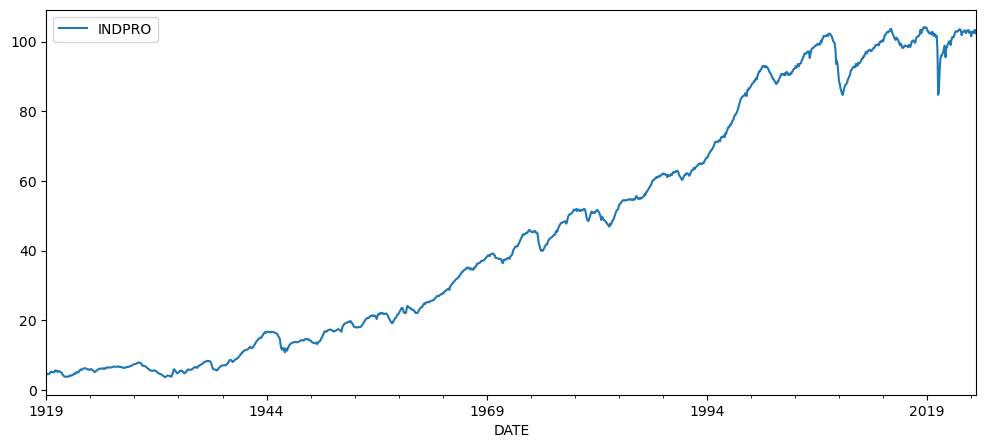

In [65]:
df.plot(figsize=(12,5));

In [66]:
df.index.freq = 'MS'

## ETS Decomposition

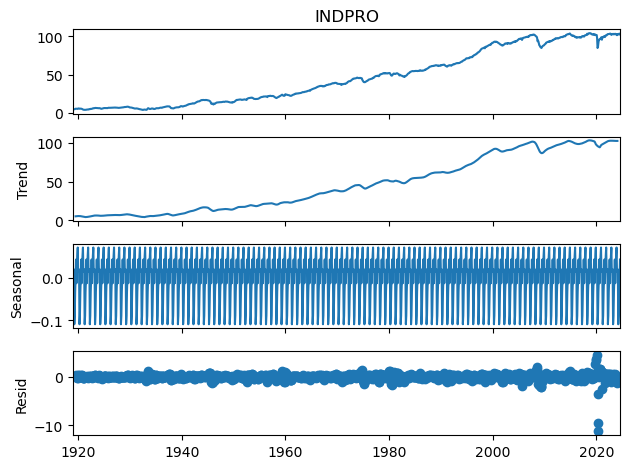

In [68]:
results = seasonal_decompose(df['INDPRO'],model='additive')
results.plot();

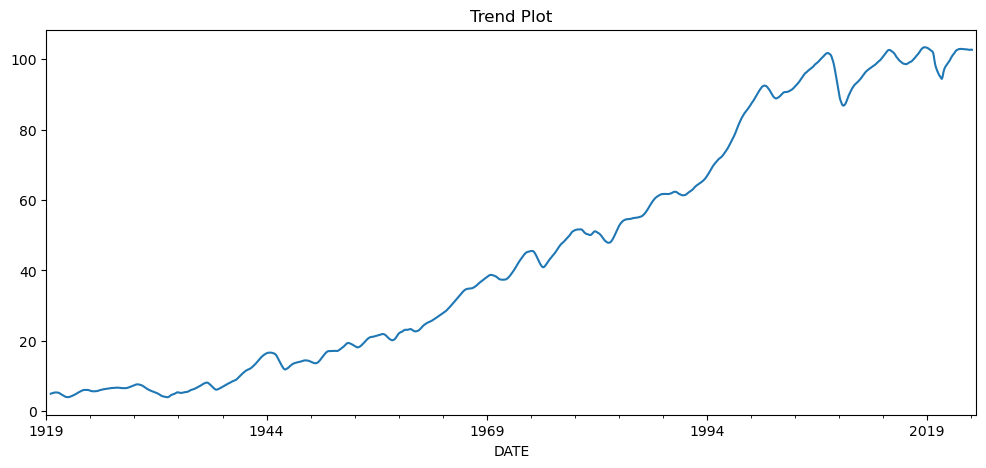

In [69]:
results.trend.plot(figsize=(12,5),title='Trend Plot');

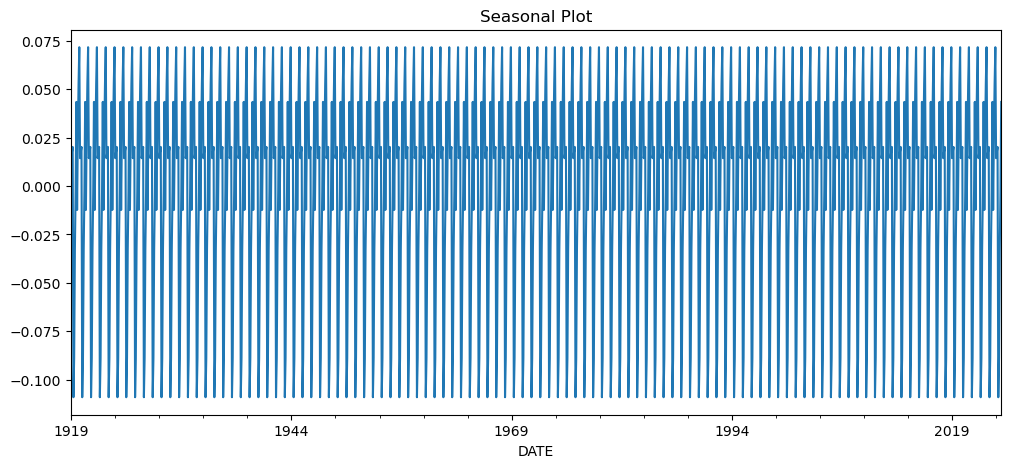

In [70]:
results.seasonal.plot(figsize=(12,5),title='Seasonal Plot');

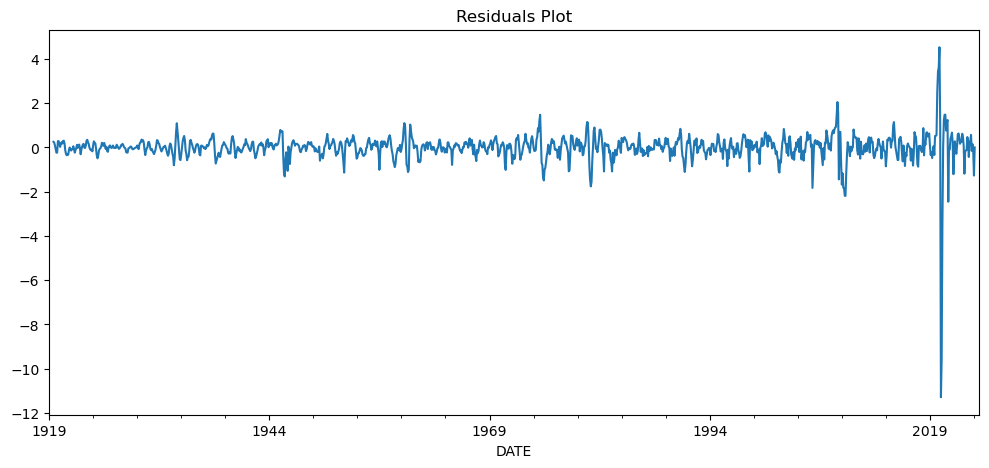

In [71]:
results.resid.plot(figsize=(12,5),title='Residuals Plot');

## Comparing SMA, EWMA and Holt-Winters methods

### Simple Moving Average (SMA)

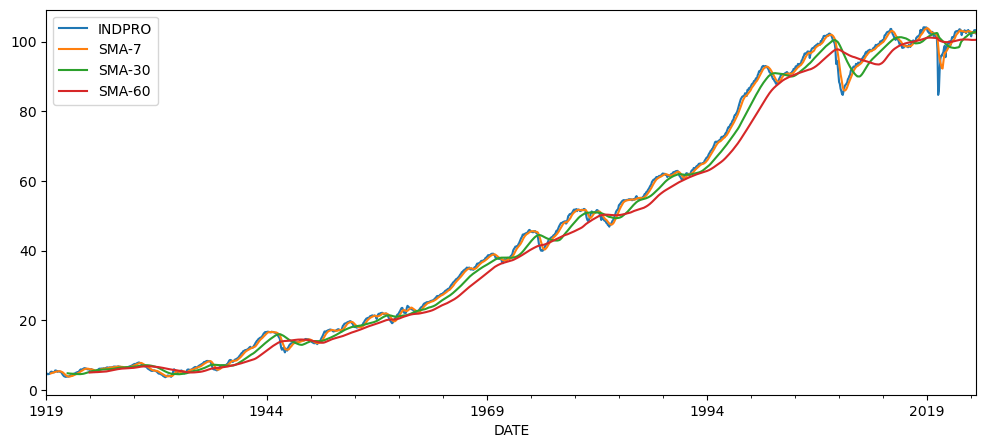

In [73]:
df['SMA-7'] = df['INDPRO'].rolling(window=7).mean()
df['SMA-30'] = df['INDPRO'].rolling(window=30).mean()
df['SMA-60'] = df['INDPRO'].rolling(window=60).mean()
df.plot(figsize=(12,5));

### Exponentially Weighted Moving Average (EWMA)

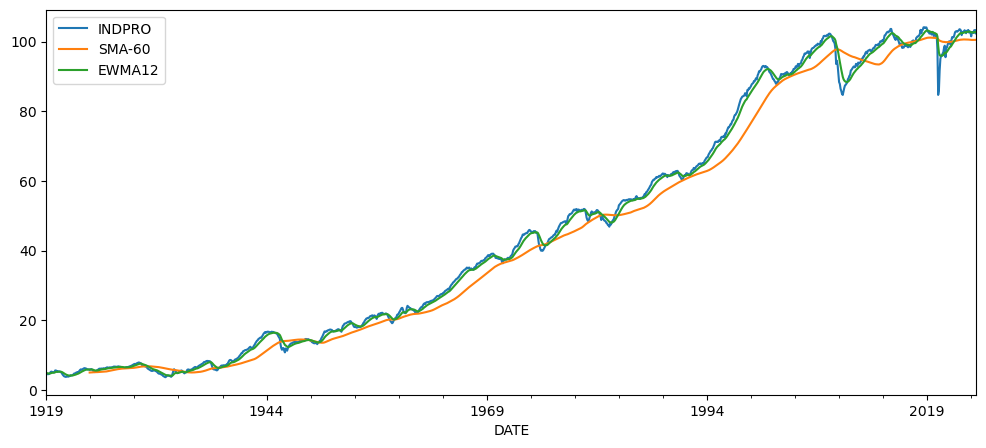

In [74]:
span = 12
alpha = 2 / (span+1)

df['EWMA12'] = df['INDPRO'].ewm(alpha=alpha,adjust=False).mean()
df[['INDPRO','SMA-60','EWMA12']].plot(figsize=(12,5));

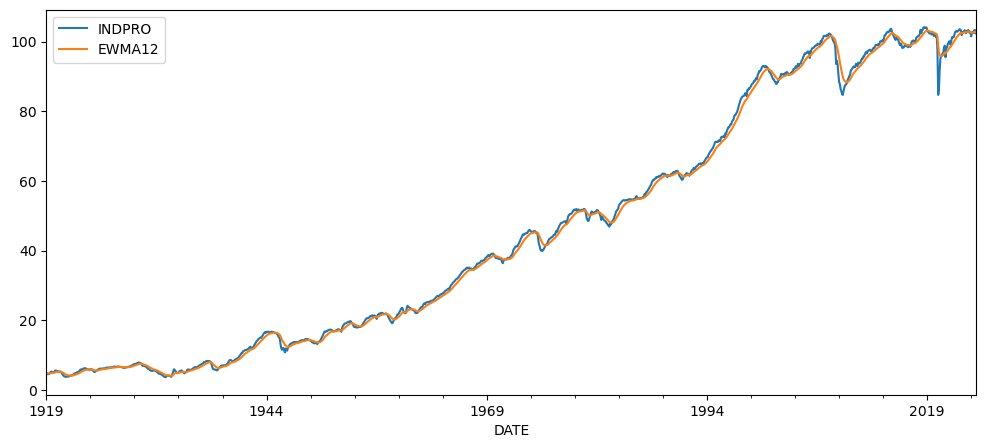

In [75]:
df[['INDPRO','EWMA12']].plot(figsize=(12,5));

### Simple Exponential Smoothing

In [76]:
ses = SimpleExpSmoothing(df['INDPRO'])
ses_model = ses.fit()
df['SES12'] = ses_model.fittedvalues
df.head()

,INDPRO,SMA-7,SMA-30,SMA-60,EWMA12,SES12
DATE,,,,,,
1919-01-01,4.8654,NaN,NaN,NaN,4.865400,4.8654
1919-02-01,4.6504,NaN,NaN,NaN,4.832323,4.8654
1919-03-01,4.5160,NaN,NaN,NaN,4.783658,4.6504
1919-04-01,4.5966,NaN,NaN,NaN,4.754880,4.5160
1919-05-01,4.6235,NaN,NaN,NaN,4.734668,4.5966


In [77]:
df.tail()

,INDPRO,SMA-7,SMA-30,SMA-60,EWMA12,SES12
DATE,,,,,,
2024-04-01,102.4479,102.467429,102.623767,100.453767,102.574841,102.5186
2024-05-01,103.2156,102.558500,102.688673,100.467067,102.673419,102.4479
2024-06-01,103.2798,102.614643,102.758173,100.479355,102.766708,103.2156
2024-07-01,102.3058,102.568200,102.794547,100.484357,102.695799,103.2798
2024-08-01,103.1389,102.804757,102.837650,100.490315,102.763969,102.3058


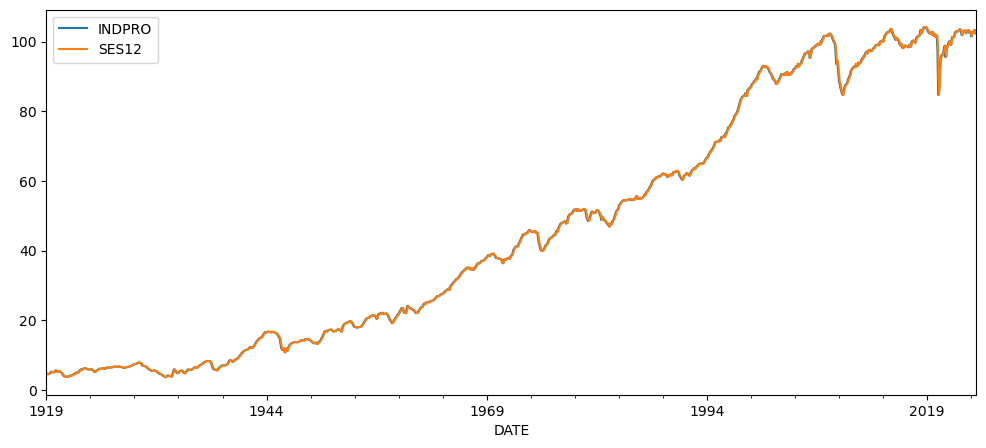

In [78]:
df[['INDPRO','SES12']].plot(figsize=(12,5));

### Double Exponential Smoothing with variants

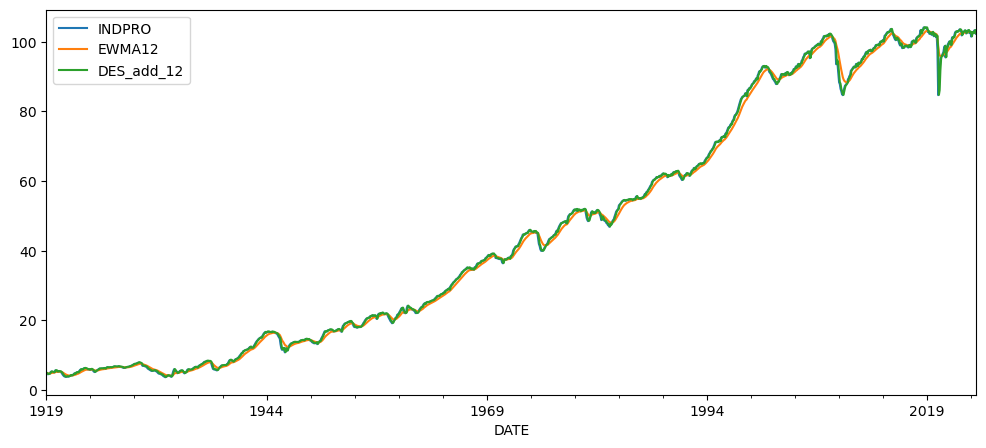

In [79]:
df['DES_add_12'] = ExponentialSmoothing(df['INDPRO'],trend='additive').fit().fittedvalues
df[['INDPRO','EWMA12','DES_add_12']].plot(figsize=(12,5));

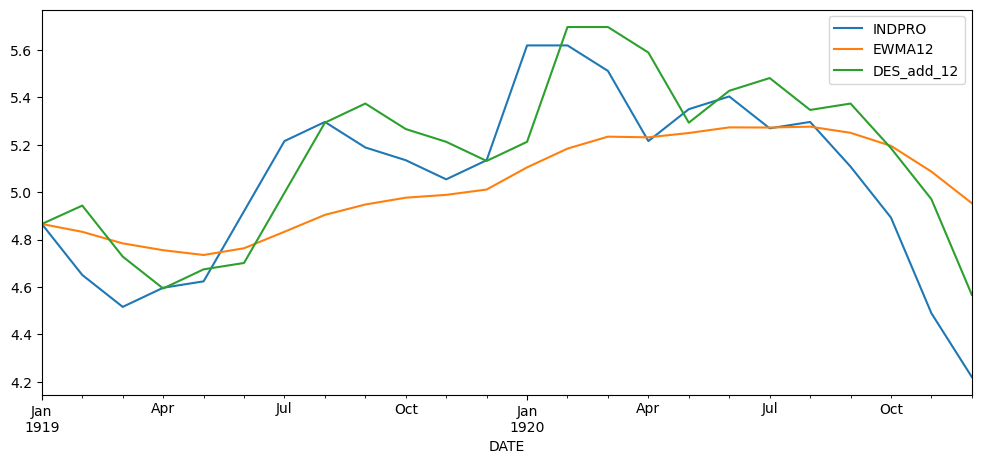

In [80]:
df[['INDPRO','EWMA12','DES_add_12']].iloc[:24].plot(figsize=(12,5));

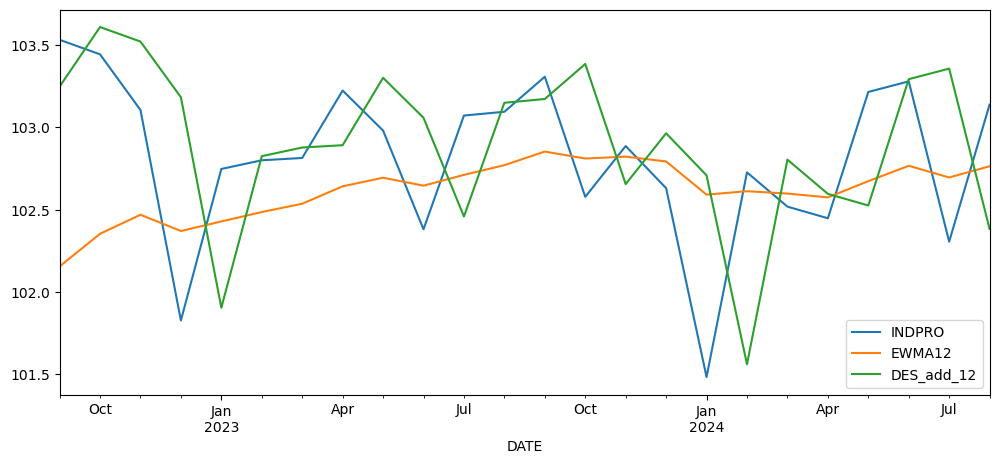

In [81]:
df[['INDPRO','EWMA12','DES_add_12']].iloc[-24:].plot(figsize=(12,5));

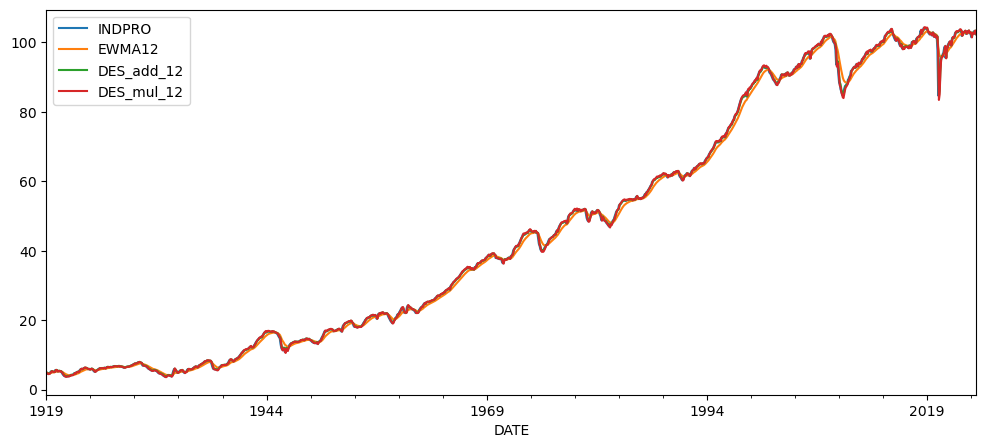

In [82]:
df['DES_mul_12'] = ExponentialSmoothing(df['INDPRO'],trend='multiplicative').fit().fittedvalues
df[['INDPRO','EWMA12','DES_add_12','DES_mul_12']].plot(figsize=(12,5));

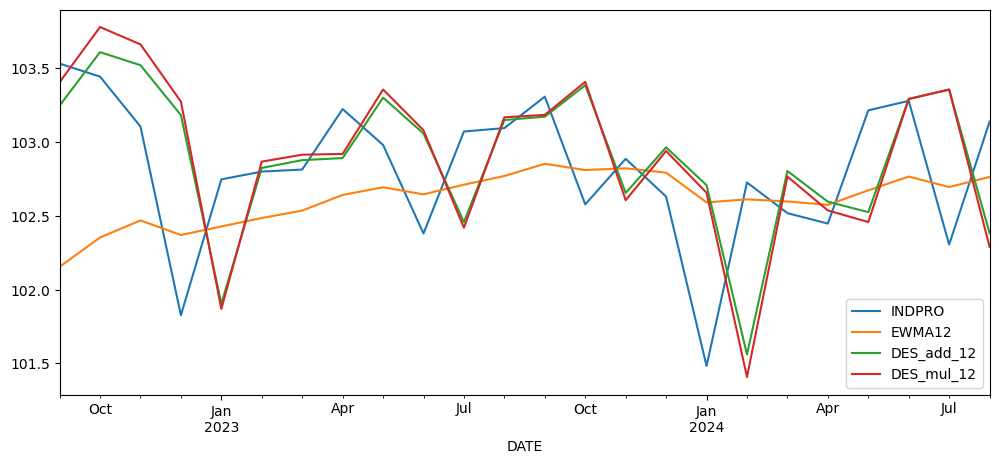

In [83]:
df[['INDPRO','EWMA12','DES_add_12','DES_mul_12']].iloc[-24:].plot(figsize=(12,5));

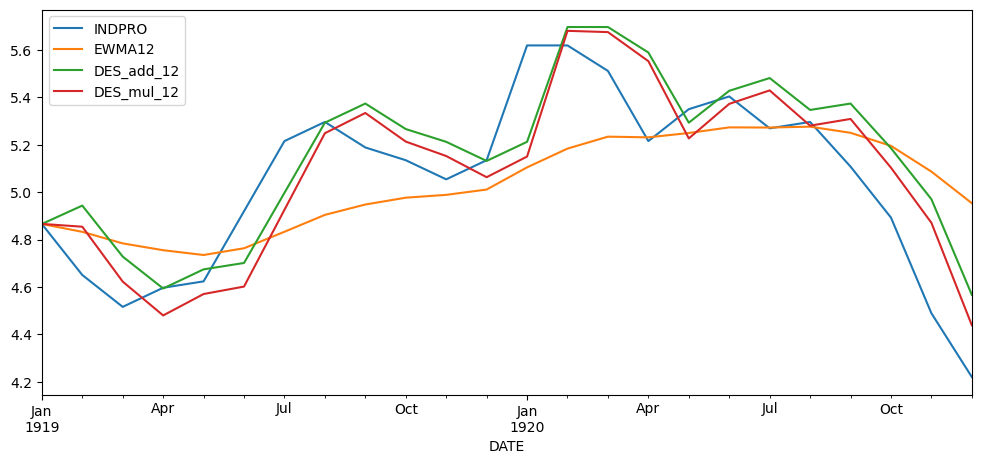

In [84]:
df[['INDPRO','EWMA12','DES_add_12','DES_mul_12']].iloc[:24].plot(figsize=(12,5));

### Triple Exponential Smoothing with variants

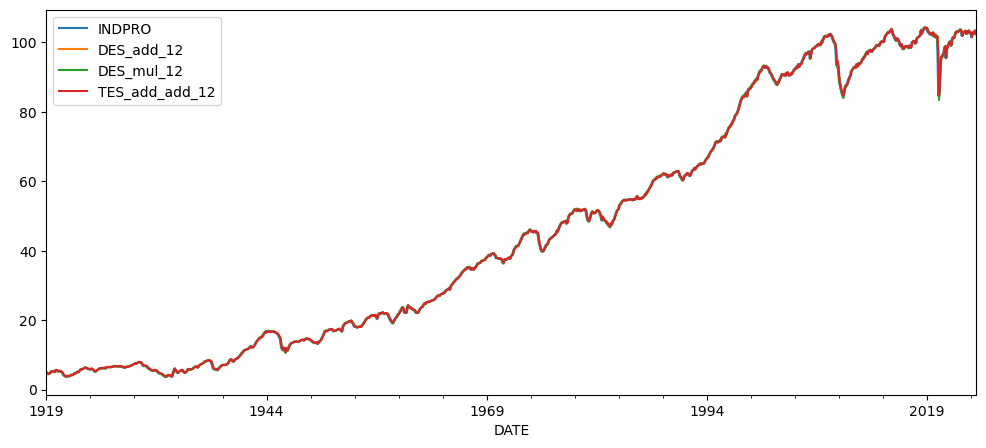

In [85]:
df['TES_add_add_12'] = ExponentialSmoothing(df['INDPRO'],trend='add',seasonal='add').fit().fittedvalues
df[['INDPRO','DES_add_12','DES_mul_12','TES_add_add_12']].plot(figsize=(12,5));

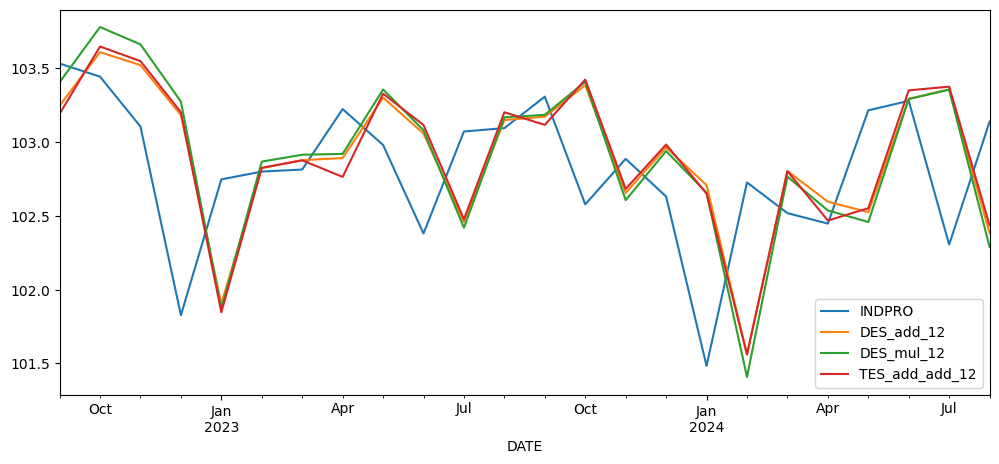

In [86]:
df[['INDPRO','DES_add_12','DES_mul_12','TES_add_add_12']].iloc[-24:].plot(figsize=(12,5));

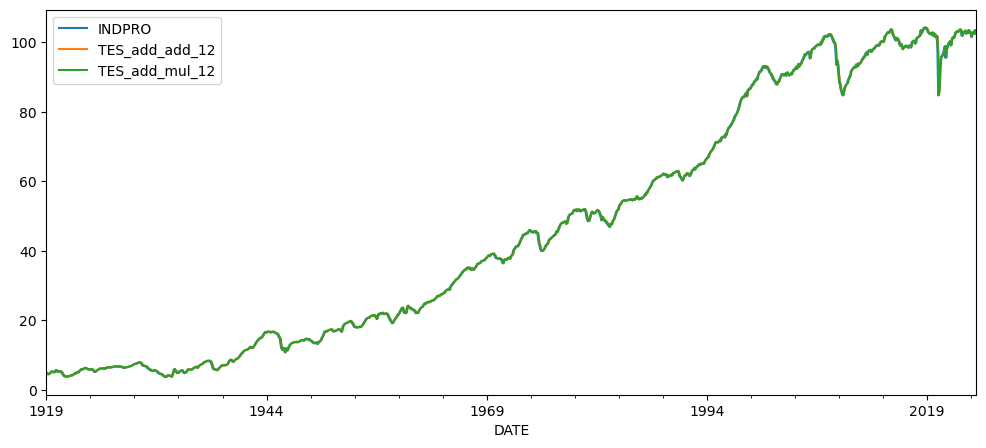

In [87]:
df['TES_add_mul_12'] = ExponentialSmoothing(df['INDPRO'],trend='add',seasonal='mul').fit().fittedvalues
df[['INDPRO','TES_add_add_12','TES_add_mul_12']].plot(figsize=(12,5));

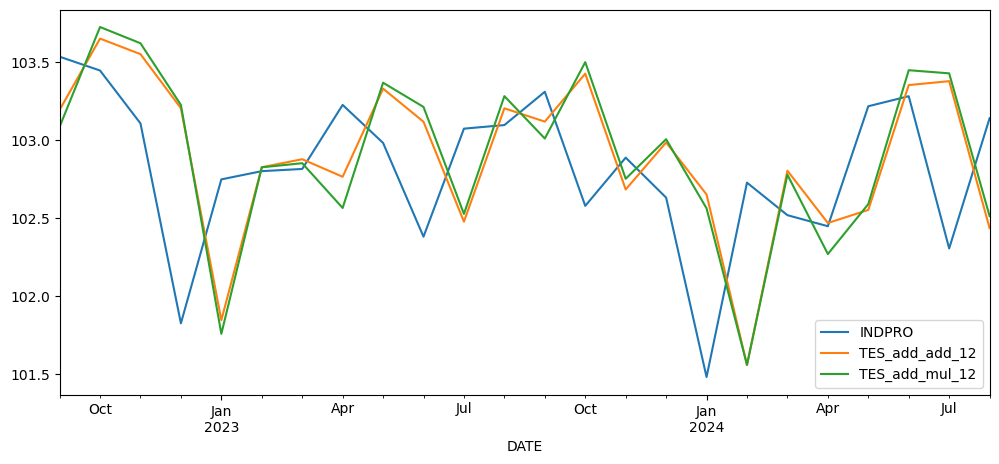

In [88]:
df[['INDPRO','TES_add_add_12','TES_add_mul_12']].iloc[-24:].plot(figsize=(12,5));

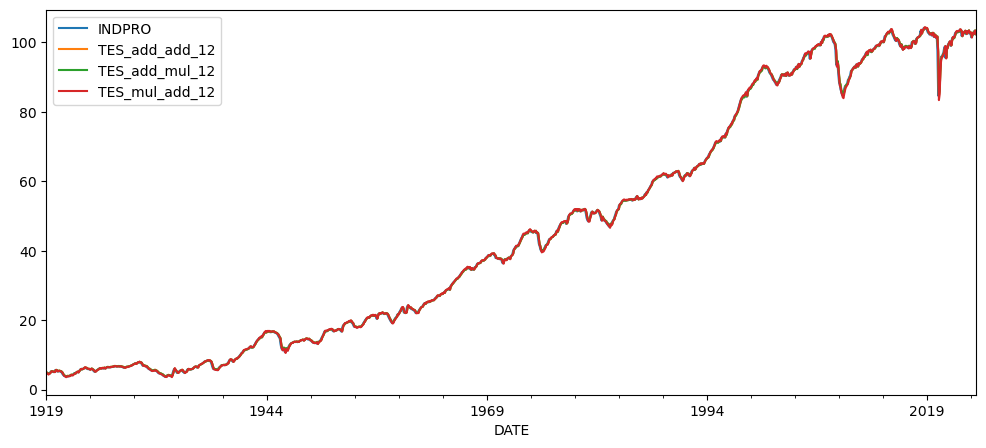

In [89]:
df['TES_mul_add_12'] = ExponentialSmoothing(df['INDPRO'],trend='mul',seasonal='add').fit().fittedvalues
df[['INDPRO','TES_add_add_12','TES_add_mul_12','TES_mul_add_12']].plot(figsize=(12,5));

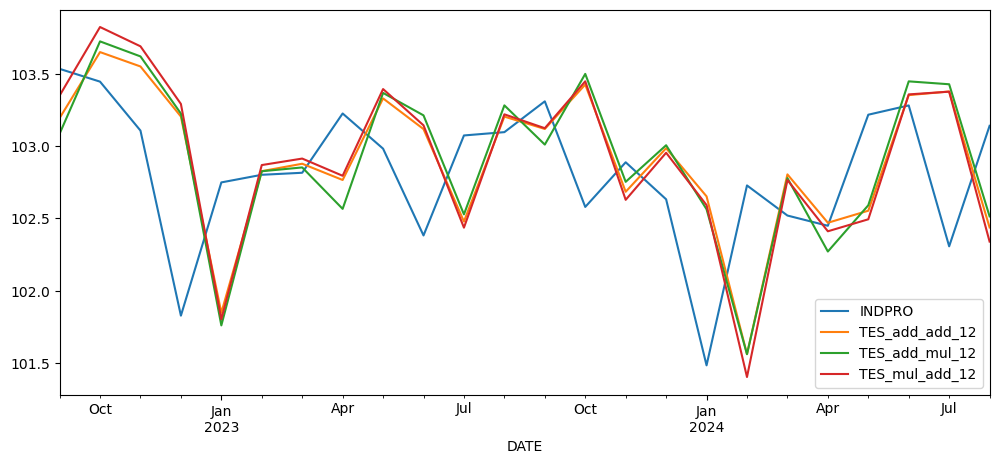

In [90]:
df[['INDPRO','TES_add_add_12','TES_add_mul_12','TES_mul_add_12']].iloc[-24:].plot(figsize=(12,5));

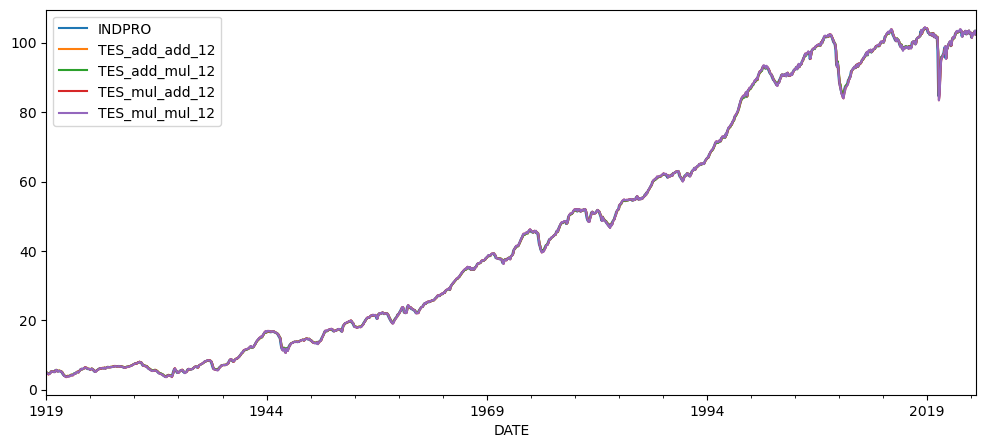

In [91]:
df['TES_mul_mul_12'] = ExponentialSmoothing(df['INDPRO'],trend='mul',seasonal='mul').fit().fittedvalues
df[['INDPRO','TES_add_add_12','TES_add_mul_12','TES_mul_add_12','TES_mul_mul_12']].plot(figsize=(12,5));

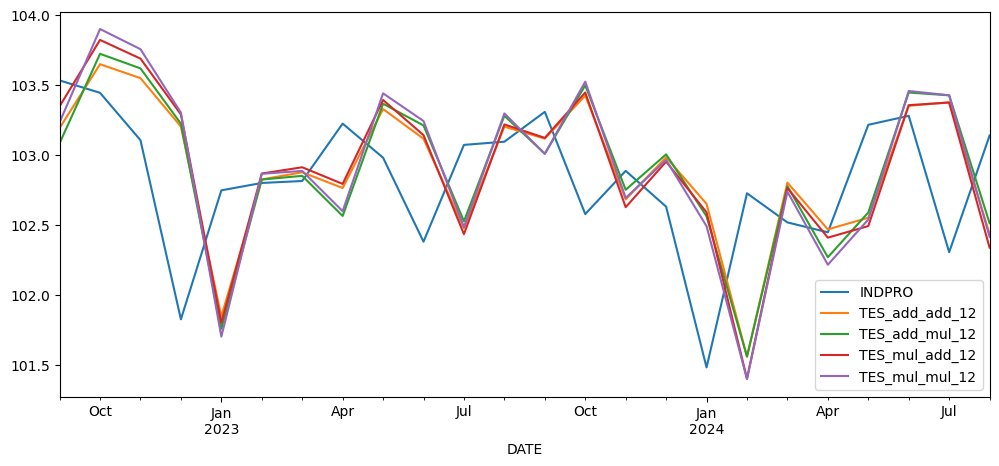

In [92]:
df[['INDPRO','TES_add_add_12','TES_add_mul_12','TES_mul_add_12','TES_mul_mul_12']].iloc[-24:].plot(figsize=(12,5));

### Holt-Winters

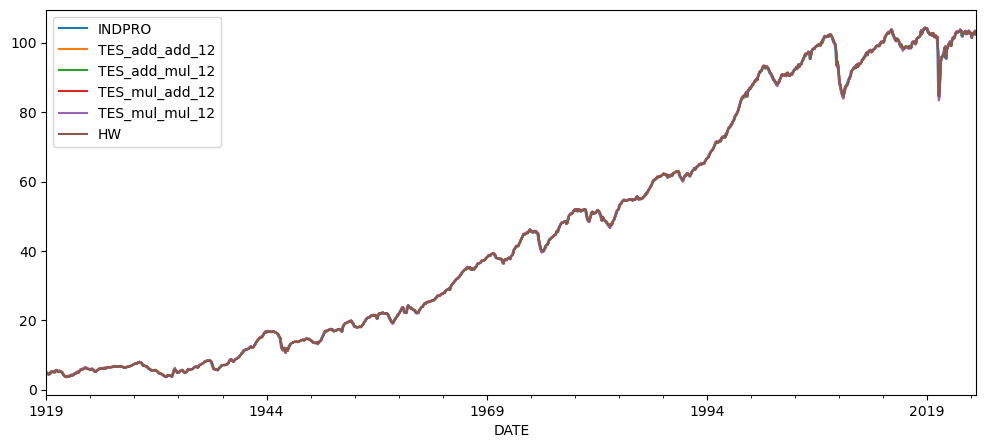

In [93]:
df['HW'] = Holt(df['INDPRO']).fit().fittedvalues
df[['INDPRO','TES_add_add_12','TES_add_mul_12','TES_mul_add_12','TES_mul_mul_12','HW']].plot(figsize=(12,5));

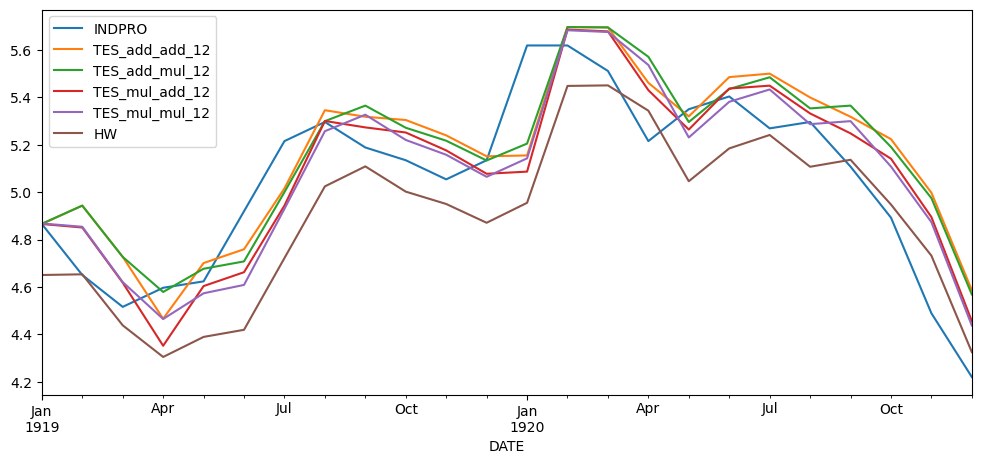

In [94]:
df[['INDPRO','TES_add_add_12','TES_add_mul_12','TES_mul_add_12','TES_mul_mul_12','HW']].iloc[:24].plot(figsize=(12,5));

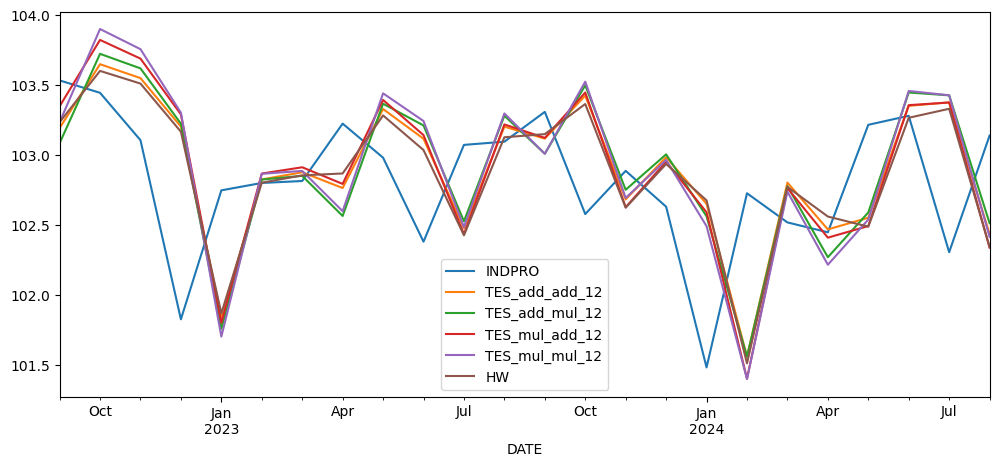

In [95]:
df[['INDPRO','TES_add_add_12','TES_add_mul_12','TES_mul_add_12','TES_mul_mul_12','HW']].iloc[-24:].plot(figsize=(12,5));

In [96]:
df.head()

,INDPRO,SMA-7,SMA-30,SMA-60,EWMA12,SES12,DES_add_12,DES_mul_12,TES_add_add_12,TES_add_mul_12,TES_mul_add_12,TES_mul_mul_12,HW
DATE,,,,,,,,,,,,,
1919-01-01,4.8654,NaN,NaN,NaN,4.865400,4.8654,4.865423,4.865759,4.865217,4.866427,4.865411,4.867615,4.650400
1919-02-01,4.6504,NaN,NaN,NaN,4.832323,4.8654,4.942964,4.853885,4.943123,4.942854,4.850620,4.853721,4.653272
1919-03-01,4.5160,NaN,NaN,NaN,4.783658,4.6504,4.727964,4.622483,4.726797,4.726644,4.618049,4.620436,4.438234
1919-04-01,4.5966,NaN,NaN,NaN,4.754880,4.5160,4.593564,4.479899,4.466083,4.578847,4.352136,4.464872,4.304872
1919-05-01,4.6235,NaN,NaN,NaN,4.734668,4.5966,4.674164,4.570183,4.700747,4.676741,4.603704,4.573325,4.389369


### Comparing all the above models/techniques

In [97]:
print("RMSE of SES12:",rmse(df['INDPRO'],df['SES12']))
print("RMSE of DES_add_12:",rmse(df['INDPRO'],df['DES_add_12']))
print("RMSE of DES_mul_12:",rmse(df['INDPRO'],df['DES_mul_12']))
print("RMSE of TES_add_add_12:",rmse(df['INDPRO'],df['TES_add_add_12']))
print("RMSE of TES_add_mul_12:",rmse(df['INDPRO'],df['TES_add_mul_12']))
print("RMSE of TES_mul_add_12:",rmse(df['INDPRO'],df['TES_mul_add_12']))
print("RMSE of TES_mul_mul_12:",rmse(df['INDPRO'],df['TES_mul_mul_12']))
print("RMSE of Holt-Winters Method:",rmse(df['INDPRO'],df['HW']))

RMSE of SES12: 0.606767193730515
RMSE of DES_add_12: 0.6017931608922135
RMSE of DES_mul_12: 0.6035296957327638
RMSE of TES_add_add_12: 0.5995445583976425
RMSE of TES_add_mul_12: 0.5967931959002551
RMSE of TES_mul_add_12: 0.6011557588594424
RMSE of TES_mul_mul_12: 0.5983414585922241
RMSE of Holt-Winters Method: 0.6041629316023579


## Leveraging descriptive statistics tests(stationarity, autocorrelation, etc.) to examine nature of time series data

In [99]:
def adf_test(series,title=''):
    '''
        Generates the results of Augmented Dickey-Fuller test on time series data
    '''
    print(f"Augmented Dickey-Fuller Test: {title}")
    adf_results = adfuller(series.dropna(),autolag='AIC')
    df_results = pd.Series(adf_results[:4],index=['t-statistic','p-value','# lags','# observations'])

    for key, val in adf_results[4].items():
        df_results[f'critical_value_{key}'] = val

    print(df_results.to_string())

    if adf_results[1] <= 0.05:
        print("Strong evidence against the null hypothesis.")
        print("Reject the null hypothesis.")
        print("Data has no unit root and is stationary.")
    else:
        print("Weak evidence against the null hypothesis.")
        print("Fail to reject the null hypothesis.")
        print("Data has a unit root and is non-stationary.")

In [100]:
adf_test(df['INDPRO'])

Augmented Dickey-Fuller Test: 
t-statistic              0.345388
p-value                  0.979334
# lags                  13.000000
# observations        1254.000000
critical_value_1%       -3.435575
critical_value_5%       -2.863848
critical_value_10%      -2.567999
Weak evidence against the null hypothesis.
Fail to reject the null hypothesis.
Data has a unit root and is non-stationary.


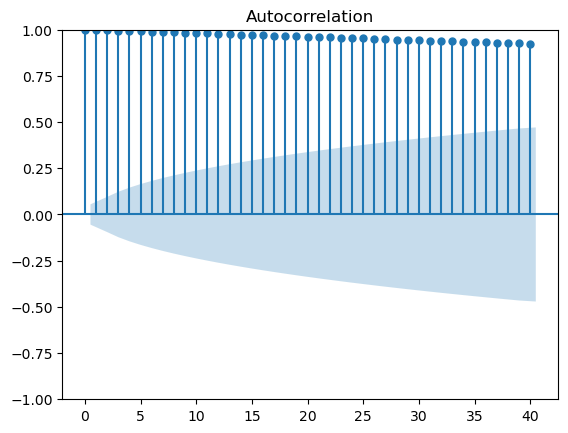

In [101]:
plot_acf(df['INDPRO'],lags=40);

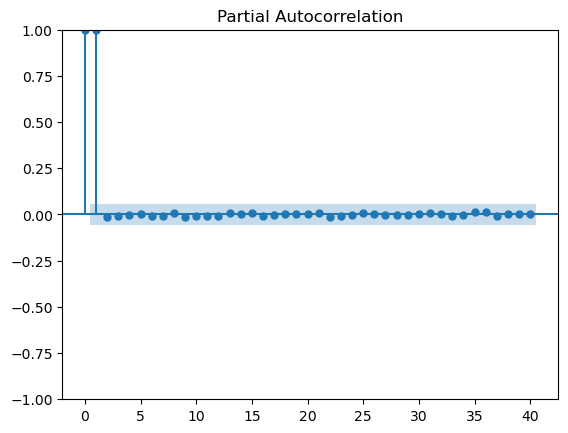

In [102]:
plot_pacf(df['INDPRO'],lags=40);

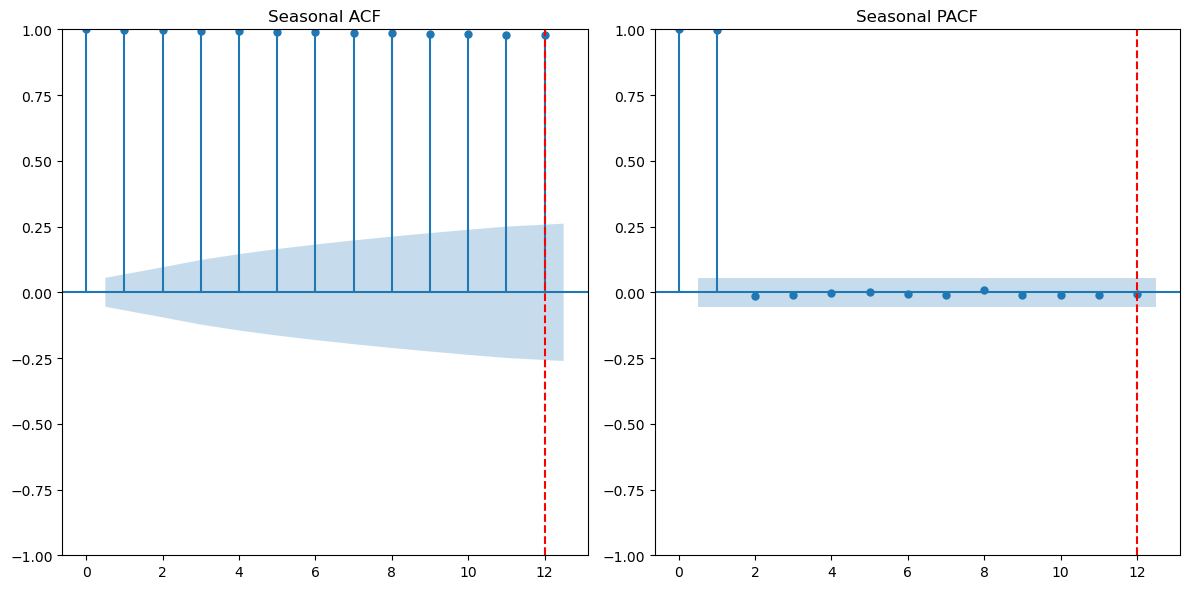

In [103]:
seasonal_period = 12

# Plot Seasonal ACF
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(df['INDPRO'], lags=seasonal_period, ax=plt.gca(), title='Seasonal ACF')
plt.axvline(x=seasonal_period, linestyle='--', color='red')  # Highlight seasonal lag

# Plot Seasonal PACF
plt.subplot(1, 2, 2)
plot_pacf(df['INDPRO'], lags=seasonal_period, ax=plt.gca(), title='Seasonal PACF')
plt.axvline(x=seasonal_period, linestyle='--', color='red')  # Highlight seasonal lag

plt.tight_layout()
plt.show()

From the above seasonal ACF and PACF plots, we can infer that the most probable orders of the SARIMA model(P,D,Q) could be (1,1,0).

In [105]:
df['INDPRO_diff1'] = diff(df['INDPRO'],k_diff=1) # Differencing the time series data
adf_test(df['INDPRO_diff1'])

Augmented Dickey-Fuller Test: 
t-statistic          -9.111992e+00
p-value               3.380038e-15
# lags                1.200000e+01
# observations        1.254000e+03
critical_value_1%    -3.435575e+00
critical_value_5%    -2.863848e+00
critical_value_10%   -2.567999e+00
Strong evidence against the null hypothesis.
Reject the null hypothesis.
Data has no unit root and is stationary.


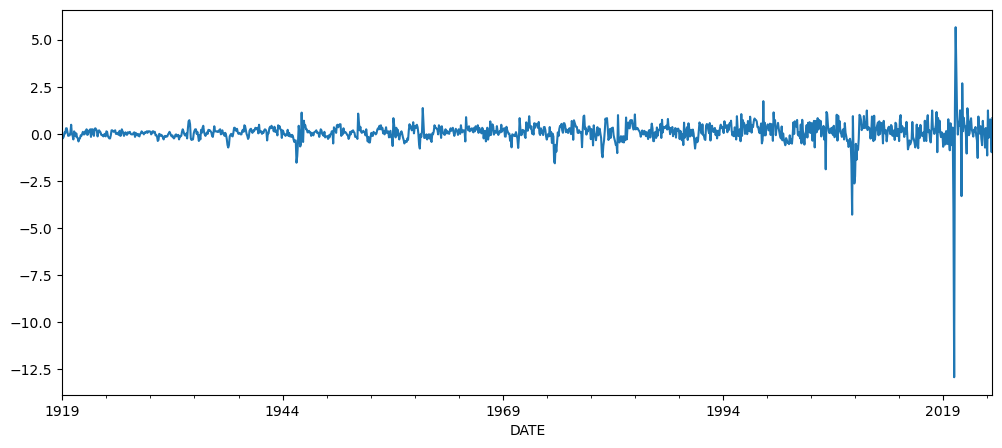

In [106]:
df['INDPRO_diff1'].plot(figsize=(12,5));

## Using Auto ARIMA to determine ARIMA orders

In [108]:
auto_arima(df['INDPRO'],seasonal=True,m=12,suppress_warnings=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1107.593
Date:                Tue, 08 Oct 2024   AIC                           2223.186
Time:                        19:46:45   BIC                           2243.764
Sample:                    01-01-1919   HQIC                          2230.917
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0777      0.026      2.935      0.003       0.026       0.130
ma.L1          0.2736      0.006     48.152      0.000       0.262       0.285
ma.L2         -0.0420      0.007     -5.838      0.000      -0.056      -0.028
sigma2         0.3364      0.002    154.751      0.000       0.332       0.341
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1117743.64
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              16.95   Skew:                            -6.63
Prob(H) (two-sided):                  0.00   Kurtosis:                       147.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [109]:
auto_arima(df['INDPRO'],start_p=0,start_q=0,start_P=0,start_Q=0,max_p=6,max_q=5,max_d=4,max_P=5,max_Q=5,max_D=4,seasonal=True,m=12,trace=True,suppress_warnings=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2313.720, Time=0.25 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2240.922, Time=0.70 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2225.561, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2332.578, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2223.578, Time=0.30 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2225.564, Time=0.48 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2227.577, Time=0.88 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2223.551, Time=0.43 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2225.550, Time=1.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=2225.550, Time=1.03 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2226.633, Time=3.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2239.222, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=2224.470, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=2227.222, Time=1.83 sec
 ARIMA(0,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1107.593
Date:                Tue, 08 Oct 2024   AIC                           2223.186
Time:                        19:47:04   BIC                           2243.764
Sample:                    01-01-1919   HQIC                          2230.917
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0777      0.026      2.935      0.003       0.026       0.130
ma.L1          0.2736      0.006     48.152      0.000       0.262       0.285
ma.L2         -0.0420      0.007     -5.838      0.000      -0.056      -0.028
sigma2         0.3364      0.002    154.751      0.000       0.332       0.341
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1117743.64
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              16.95   Skew:                            -6.63
Prob(H) (two-sided):                  0.00   Kurtosis:                       147.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Dividing the dataset into train and test sets

In [111]:
df.shape

(1268, 14)

In [112]:
train = df[:1244]
test = df[1244:]
train.shape, test.shape

((1244, 14), (24, 14))

## ARIMA Modeling

### Training and evaluating ARIMA(0,1,2) model

In [114]:
arima = ARIMA(train['INDPRO_diff1'],order=(0,1,2))
arima_model = arima.fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           INDPRO_diff1   No. Observations:                 1244
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1091.890
Date:                Tue, 08 Oct 2024   AIC                           2189.780
Time:                        19:47:05   BIC                           2205.156
Sample:                    01-01-1919   HQIC                          2195.562
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6968      0.005   -139.803      0.000      -0.707      -0.687
ma.L2         -0.3005      0.005    -55.366      0.000      -0.311      -0.290
sigma2         0.3341      0.002    176.338      0.000       0.330       0.338
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):           1144433.38
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):              17.92   Skew:                            -6.56
Prob(H) (two-sided):                  0.00   Kurtosis:                       151.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
test_predictions = arima_model.predict(start=len(train),end=len(train)+len(test)-1,typ='levels').rename('ARIMA(0,1,2) Predictions')
test_predictions

2022-09-01    0.077394
2022-10-01    0.086343
2022-11-01    0.086343
2022-12-01    0.086343
2023-01-01    0.086343
2023-02-01    0.086343
2023-03-01    0.086343
2023-04-01    0.086343
2023-05-01    0.086343
2023-06-01    0.086343
2023-07-01    0.086343
2023-08-01    0.086343
2023-09-01    0.086343
2023-10-01    0.086343
2023-11-01    0.086343
2023-12-01    0.086343
2024-01-01    0.086343
2024-02-01    0.086343
2024-03-01    0.086343
2024-04-01    0.086343
2024-05-01    0.086343
2024-06-01    0.086343
2024-07-01    0.086343
2024-08-01    0.086343
Freq: MS, Name: ARIMA(0,1,2) Predictions, dtype: float64

In [116]:
true_predictions = df['INDPRO'].iloc[-24-1] + test_predictions.cumsum()
true_predictions

2022-09-01    103.247694
2022-10-01    103.334037
2022-11-01    103.420381
2022-12-01    103.506724
2023-01-01    103.593067
2023-02-01    103.679410
2023-03-01    103.765753
2023-04-01    103.852096
2023-05-01    103.938440
2023-06-01    104.024783
2023-07-01    104.111126
2023-08-01    104.197469
2023-09-01    104.283812
2023-10-01    104.370155
2023-11-01    104.456498
2023-12-01    104.542842
2024-01-01    104.629185
2024-02-01    104.715528
2024-03-01    104.801871
2024-04-01    104.888214
2024-05-01    104.974557
2024-06-01    105.060900
2024-07-01    105.147244
2024-08-01    105.233587
Freq: MS, Name: ARIMA(0,1,2) Predictions, dtype: float64

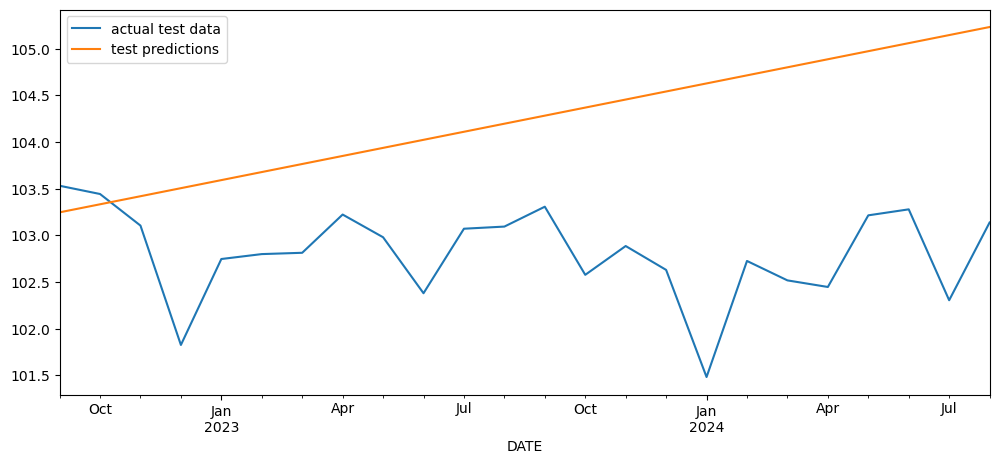

In [117]:
df['INDPRO'].iloc[1244:].plot(figsize=(12,5),legend=True,label='actual test data')
true_predictions.plot(figsize=(12,5),legend=True,label='test predictions');

In [118]:
test.shape, true_predictions.shape

((24, 14), (24,))

In [119]:
print("MAE:", meanabs(test['INDPRO'],true_predictions))
print("MSE:", mse(test['INDPRO'],true_predictions))
print("RMSE:", np.sqrt(mse(test['INDPRO'],true_predictions)))

MAE: 1.4591962171276425
MSE: 2.739553305958111
RMSE: 1.6551596013551415


### Forecasting into unknown future

In [121]:
arima = ARIMA(df['INDPRO_diff1'],order=(0,1,2))
arima_model = arima.fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           INDPRO_diff1   No. Observations:                 1268
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1119.498
Date:                Tue, 08 Oct 2024   AIC                           2244.997
Time:                        19:47:06   BIC                           2260.430
Sample:                    01-01-1919   HQIC                          2250.795
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7099      0.005   -137.170      0.000      -0.720      -0.700
ma.L2         -0.2877      0.005    -52.418      0.000      -0.298      -0.277
sigma2         0.3376      0.002    172.648      0.000       0.334       0.341
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):           1111214.94
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):              17.89   Skew:                            -6.46
Prob(H) (two-sided):                  0.00   Kurtosis:                       147.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
forecast = arima_model.predict(start=len(df),end=len(df)+len(test)-1,typ='levels').rename('ARIMA(0,1,2) Forecast')
forecast

2024-09-01    0.381656
2024-10-01    0.082647
2024-11-01    0.082647
2024-12-01    0.082647
2025-01-01    0.082647
2025-02-01    0.082647
2025-03-01    0.082647
2025-04-01    0.082647
2025-05-01    0.082647
2025-06-01    0.082647
2025-07-01    0.082647
2025-08-01    0.082647
2025-09-01    0.082647
2025-10-01    0.082647
2025-11-01    0.082647
2025-12-01    0.082647
2026-01-01    0.082647
2026-02-01    0.082647
2026-03-01    0.082647
2026-04-01    0.082647
2026-05-01    0.082647
2026-06-01    0.082647
2026-07-01    0.082647
2026-08-01    0.082647
Freq: MS, Name: ARIMA(0,1,2) Forecast, dtype: float64

In [123]:
true_predictions = df['INDPRO'].iloc[-24-1] + forecast.cumsum()
true_predictions

2024-09-01    103.551956
2024-10-01    103.634604
2024-11-01    103.717251
2024-12-01    103.799898
2025-01-01    103.882546
2025-02-01    103.965193
2025-03-01    104.047840
2025-04-01    104.130488
2025-05-01    104.213135
2025-06-01    104.295782
2025-07-01    104.378430
2025-08-01    104.461077
2025-09-01    104.543724
2025-10-01    104.626372
2025-11-01    104.709019
2025-12-01    104.791666
2026-01-01    104.874314
2026-02-01    104.956961
2026-03-01    105.039608
2026-04-01    105.122256
2026-05-01    105.204903
2026-06-01    105.287550
2026-07-01    105.370198
2026-08-01    105.452845
Freq: MS, Name: ARIMA(0,1,2) Forecast, dtype: float64

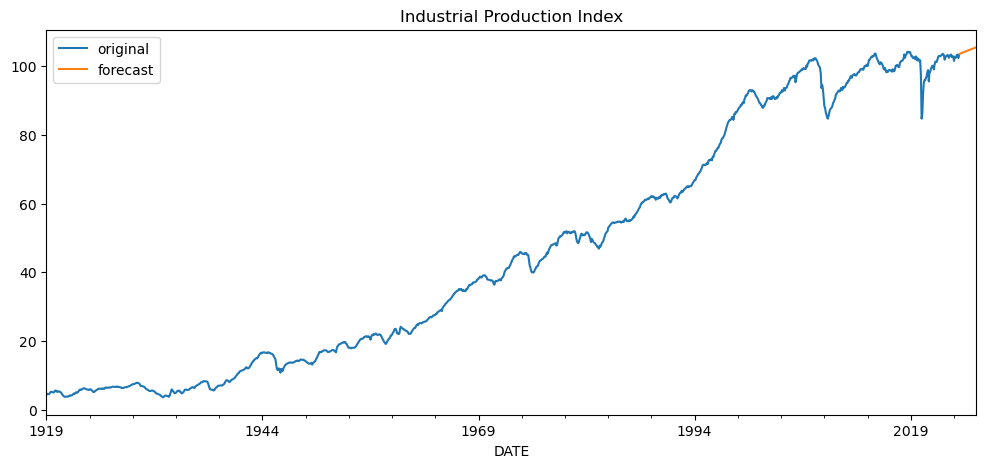

In [124]:
df['INDPRO'].plot(figsize=(12,5),legend=True,label='original',title='Industrial Production Index')
true_predictions.plot(figsize=(12,5),legend=True,label='forecast');

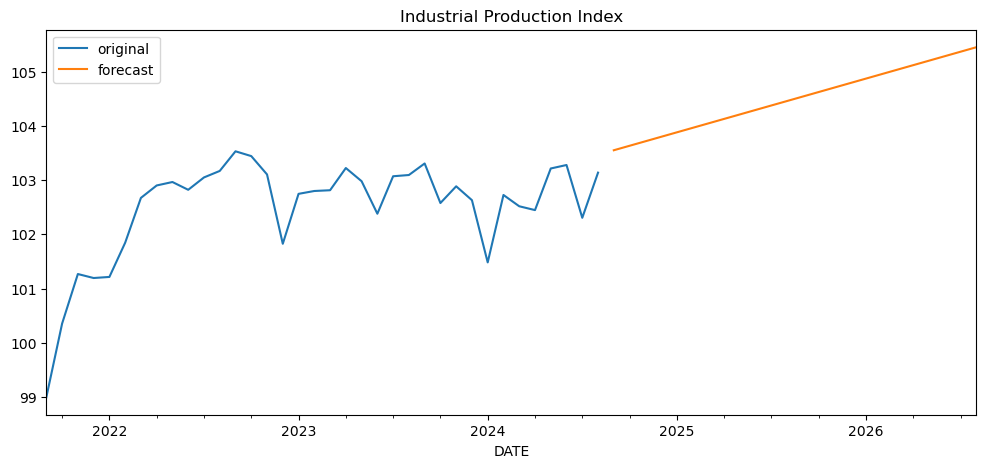

In [125]:
df['INDPRO'].iloc[-36:].plot(figsize=(12,5),legend=True,label='original',title='Industrial Production Index')
true_predictions.plot(figsize=(12,5),legend=True,label='forecast');

## SARIMA Modeling

### Determining the most optimal SARIMA orders

In [233]:
order_vals = [1,2,3,4] # Determining the most optimal seasonal order of SARIMA

min_aic = np.inf
final_P = -1
final_Q = -1

for i in tqdm(range(len(order_vals))):
    for j in range(len(order_vals)):
        p, q = order_vals[i], order_vals[j]
        sarima_model = SARIMAX(train['INDPRO'],order=(0,1,2),seasonal_order=(p,1,q,12)).fit() # Seasonal differencing term is assumed to be 1
        
        if min_aic > sarima_model.aic:
            min_aic = sarima_model.aic
            final_P = p
            final_Q = q

print(f"Recommended SARIMA orders: (0,1,2),({final_P},1,{final_Q},12)")
print("Least AIC value obtained:", min_aic)

  0%|          | 0/4 [00:00<?, ?it/s]

Recommended SARIMA orders: (0,1,2),(2,1,2,12)
Least AIC value obtained: 2183.3909004219217


The most optimal seasonal order of the SARIMA model is (2,1,2,12).

### Training and evaluating the SARIMA(0,1,2)(2,1,2,12) model

In [237]:
sarima = SARIMAX(train['INDPRO'],order=(0,1,2),seasonal_order=(2,1,2,12))
sarima_model = sarima.fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             INDPRO   No. Observations:                 1244
Model:             SARIMAX(0, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -1084.695
Date:                            Tue, 08 Oct 2024   AIC                           2183.391
Time:                                    20:23:05   BIC                           2219.200
Sample:                                01-01-1919   HQIC                          2196.863
                                     - 08-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2918      0.006     49.811      0.000       0.280       0.303
ma.L2         -0.0379      0.007     -5.316      0.000      -0.052      -0.024
ar.S.L12       0.6165      0.157      3.920      0.000       0.308       0.925
ar.S.L24      -0.1328      0.026     -5.108      0.000      -0.184      -0.082
ma.S.L12      -1.5997      0.162     -9.860      0.000      -1.918      -1.282
ma.S.L24       0.6307      0.157      4.019      0.000       0.323       0.938
sigma2         0.3326      0.003    119.616      0.000       0.327       0.338
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1071835.66
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              16.67   Skew:                            -6.67
Prob(H) (two-sided):                  0.00   Kurtosis:                       146.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [239]:
test_predictions = sarima_model.predict(start=len(train),end=len(train)+len(test)-1,typ='levels').rename('SARIMA(0,1,2)(1,1,1,12) Predictions')
test_predictions

2022-09-01    103.007857
2022-10-01    103.223147
2022-11-01    103.315741
2022-12-01    103.357199
2023-01-01    103.238535
2023-02-01    103.629412
2023-03-01    103.590675
2023-04-01    104.049838
2023-05-01    103.987976
2023-06-01    103.947557
2023-07-01    103.966149
2023-08-01    104.081040
2023-09-01    104.041770
2023-10-01    104.113618
2023-11-01    104.150136
2023-12-01    104.273974
2024-01-01    104.148874
2024-02-01    104.241644
2024-03-01    104.122156
2024-04-01    104.022152
2024-05-01    104.046008
2024-06-01    104.309593
2024-07-01    104.452745
2024-08-01    104.610319
Freq: MS, Name: SARIMA(0,1,2)(1,1,1,12) Predictions, dtype: float64

In [241]:
print("MAE:", meanabs(test['INDPRO'],test_predictions))
print("MSE:", mse(test['INDPRO'],test_predictions))
print("RMSE:", np.sqrt(mse(test['INDPRO'],test_predictions)))

MAE: 1.1614543369676482
MSE: 1.6804916109288994
RMSE: 1.2963377688430202


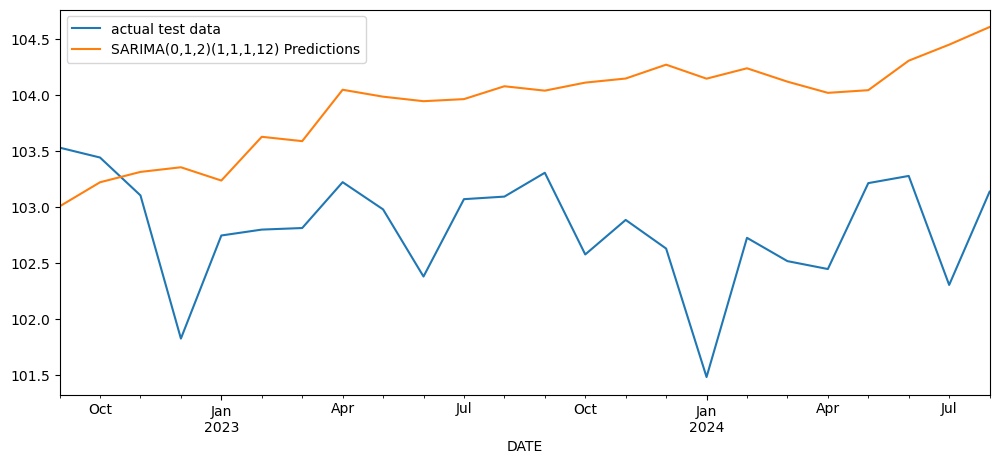

In [243]:
test['INDPRO'].plot(figsize=(12,5),legend=True,label='actual test data')
test_predictions.plot(legend=True);

### Forecasting into unknown future

In [250]:
sarima = SARIMAX(df['INDPRO'],order=(0,1,2),seasonal_order=(2,1,2,12))
sarima_model = sarima.fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             INDPRO   No. Observations:                 1268
Model:             SARIMAX(0, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -1112.725
Date:                            Tue, 08 Oct 2024   AIC                           2239.450
Time:                                    20:25:53   BIC                           2275.394
Sample:                                01-01-1919   HQIC                          2252.960
                                     - 08-01-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2744      0.006     45.607      0.000       0.263       0.286
ma.L2         -0.0397      0.007     -5.706      0.000      -0.053      -0.026
ar.S.L12       0.6076      0.147      4.147      0.000       0.320       0.895
ar.S.L24      -0.1259      0.025     -5.063      0.000      -0.175      -0.077
ma.S.L12      -1.5999      0.151    -10.627      0.000      -1.895      -1.305
ma.S.L24       0.6262      0.147      4.263      0.000       0.338       0.914
sigma2         0.3360      0.003    125.804      0.000       0.331       0.341
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1060871.36
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              17.05   Skew:                            -6.63
Prob(H) (two-sided):                  0.00   Kurtosis:                       144.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [252]:
forecast = sarima_model.predict(start=len(df),end=len(df)+len(test)-1,typ='levels').rename('SARIMAX(0,1,2)(2,1,2,12) Forecast')
forecast

2024-09-01    103.316159
2024-10-01    103.438680
2024-11-01    103.592880
2024-12-01    103.872617
2025-01-01    103.675150
2025-02-01    103.704099
2025-03-01    103.658276
2025-04-01    103.306509
2025-05-01    103.426417
2025-06-01    103.849610
2025-07-01    103.992468
2025-08-01    104.189555
2025-09-01    104.035959
2025-10-01    104.313665
2025-11-01    104.463024
2025-12-01    104.707948
2026-01-01    104.689631
2026-02-01    104.527721
2026-03-01    104.542651
2026-04-01    104.037214
2026-05-01    104.098099
2026-06-01    104.568974
2026-07-01    104.914613
2026-08-01    105.046205
Freq: MS, Name: SARIMAX(0,1,2)(2,1,2,12) Forecast, dtype: float64

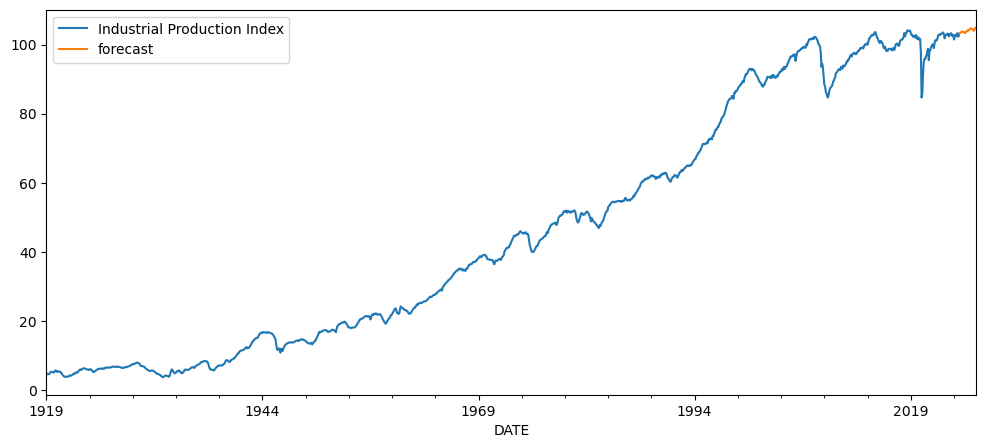

In [256]:
df['INDPRO'].plot(figsize=(12,5),legend=True,label='Industrial Production Index')
forecast.plot(legend=True,label='forecast');

It's a decent forecast from a realistic perspective. Isn't it?

## Industrial Production Index Forecasting using LSTMs

### Scaling the time series data

In [259]:
scaler = MinMaxScaler(feature_range=(0,1))
train['INDPRO'] = scaler.fit_transform(train[['INDPRO']])
test['INDPRO'] = scaler.transform(test[['INDPRO']])

### Segregating train and test data into time series batches

In [261]:
n_inputs = 24
n_features = 1

train_generator = TimeseriesGenerator(train['INDPRO'].values,train['INDPRO'].values,length=n_inputs,batch_size=1)
train_generator

In [263]:
X, y = train_generator[0]
X, y

(array([[0.01177741, 0.00963642, 0.00829806, 0.00910068, 0.00936855,
         0.01231315, 0.01525775, 0.01606037, 0.01498988, 0.01445413,
         0.01365151, 0.01445413, 0.01927284, 0.01927284, 0.01820235,
         0.01525775, 0.01659611, 0.01713086, 0.0157925 , 0.01606037,
         0.01418626, 0.01204528, 0.00803018, 0.00535346]]),
 array([0.0029446]))

In [265]:
X.shape, y.shape

((1, 24), (1,))

In [267]:
test_generator = TimeseriesGenerator(test['INDPRO'].values,test['INDPRO'].values,length=5,batch_size=1)
test_generator

### Defining the LSTM model architecture

In [270]:
model = Sequential()
model.add(LSTM(units=250,activation='relu',input_shape=(n_inputs,n_features)))
model.add(Dense(units=1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 250)                 │         252,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,251 (985.36 KB)

 Trainable params: 252,251 (985.36 KB)

 Non-trainable params: 0 (0.00 B)

In [271]:
model.compile(loss='mse',optimizer='adam')

### Training the LSTM model on train data and evaluating it on test data

In [273]:
es = EarlyStopping(monitor='val_loss',mode='min',patience=10,restore_best_weights=True,start_from_epoch=10,verbose=1)

model.fit(train_generator,
          epochs=30,
          validation_data=test_generator,
          callbacks=[es])

Epoch 1/30
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - loss: 0.0108 - val_loss: 0.1593
Epoch 2/30
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 5.8360e-04 - val_loss: 0.0909
Epoch 3/30
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 4.2913e-04 - val_loss: 0.0340
Epoch 4/30
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 4.3262e-04 - val_loss: 0.0117
Epoch 5/30
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 3.2466e-04 - val_loss: 0.0034
Epoch 6/30
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 2.4832e-04 - val_loss: 0.0025
Epoch 7/30
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 1.9897e-04 - val_loss: 6.8446e-04
Epoch 8/30
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 2.2321e-04 - val_loss: 4.1744e-05
Epoch 9/30
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 1.7590e-04 - val_loss: 0.0015
Epoch 10/30
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 9.3190e-05 - val_loss: 8.8682e-05
Epoch 11/30
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms

### Visualizing model performance

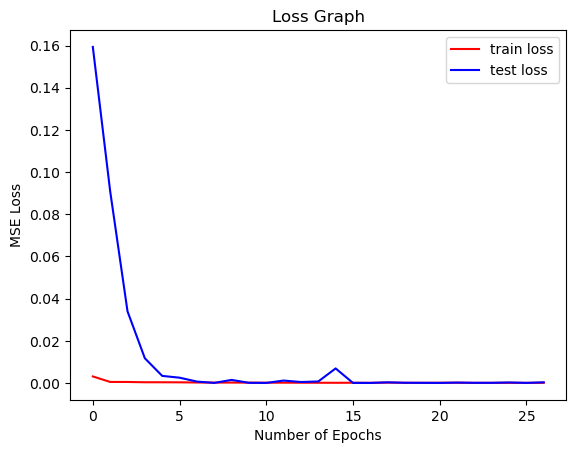

In [274]:
plt.plot(model.history.history['loss'],'r',label='train loss')
plt.plot(model.history.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('MSE Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

### Making and evaluating predictions on test data

In [275]:
test_predictions = []
first_eval_batch = train['INDPRO'].iloc[-n_inputs:].values
current_batch = first_eval_batch.reshape((1,n_inputs,n_features))

for i in range(len(test)):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

test_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[array([0.99589705], dtype=float32),
 array([1.0011165], dtype=float32),
 array([1.0060862], dtype=float32),
 array([1.0109843], dtype=float32),
 array([1.0158263], dtype=float32),
 array([1.020609], dtype=float32),
 array([1.0253257], dtype=float32),
 array([1.0299709], dtype=float32),
 array([1.0345403], dtype=float32),
 array([1.0390313], dtype=float32),
 array([1.0434414], dtype=float32),
 array([1.0477704], dtype=float32),
 array([1.0520171], dtype=float32),
 array([1.0561814], dtype=float32),
 array([1.0602636], dtype=float32),
 array([1.0642642], dtype=float32),
 array([1.0681834], dtype=float32),
 array([1.0720223], dtype=float32),
 array([1.0757815], dtype=float32),
 array([1.0794613], dtype=float32),
 array([1.0830631], dtype=float32),
 array([1.0865877], dtype=float32),
 array([1.0900357], dtype=float32),
 array([1.0934085], dtype=float32)]

In [278]:
test_predictions = np.array(test_predictions)
test_predictions

array([[0.99589705],
       [1.0011165 ],
       [1.0060862 ],
       [1.0109843 ],
       [1.0158263 ],
       [1.020609  ],
       [1.0253257 ],
       [1.0299709 ],
       [1.0345403 ],
       [1.0390313 ],
       [1.0434414 ],
       [1.0477704 ],
       [1.0520171 ],
       [1.0561814 ],
       [1.0602636 ],
       [1.0642642 ],
       [1.0681834 ],
       [1.0720223 ],
       [1.0757815 ],
       [1.0794613 ],
       [1.0830631 ],
       [1.0865877 ],
       [1.0900357 ],
       [1.0934085 ]], dtype=float32)

In [279]:
print("MAE:", mean_absolute_error(test['INDPRO'],test_predictions))
print("MSE:", mean_squared_error(test['INDPRO'],test_predictions))
print("RMSE:", np.sqrt(mean_squared_error(test['INDPRO'],test_predictions)))

MAE: 0.0608348120616622
MSE: 0.0046481609531420645
RMSE: 0.06817742260559624


In [280]:
true_predictions = scaler.inverse_transform(test_predictions.reshape(-1,1))
true_predictions

array([[103.69178 ],
       [104.21593 ],
       [104.71499 ],
       [105.206856],
       [105.6931  ],
       [106.173386],
       [106.64703 ],
       [107.11351 ],
       [107.57238 ],
       [108.02336 ],
       [108.46624 ],
       [108.900955],
       [109.327415],
       [109.745605],
       [110.15554 ],
       [110.55728 ],
       [110.95086 ],
       [111.336365],
       [111.71386 ],
       [112.0834  ],
       [112.44509 ],
       [112.799034],
       [113.14529 ],
       [113.483986]], dtype=float32)

In [281]:
true_test_data = scaler.inverse_transform(test[['INDPRO']])
true_test_data

array([[103.5326],
       [103.4442],
       [103.1058],
       [101.8266],
       [102.7476],
       [102.8003],
       [102.8143],
       [103.2241],
       [102.9809],
       [102.3809],
       [103.0722],
       [103.0951],
       [103.3081],
       [102.5781],
       [102.8868],
       [102.6309],
       [101.483 ],
       [102.7267],
       [102.5186],
       [102.4479],
       [103.2156],
       [103.2798],
       [102.3058],
       [103.1389]])

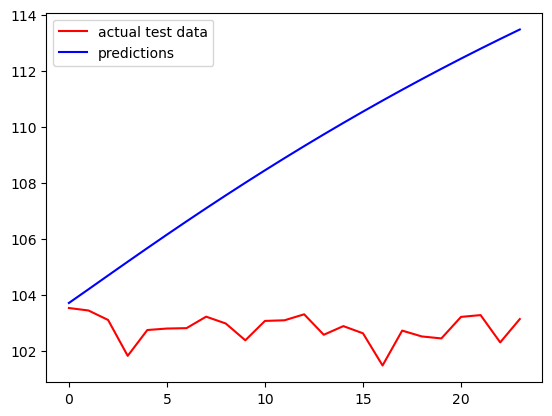

In [433]:
plt.plot(true_test_data,'r',label='actual test data')
plt.plot(true_predictions,'b',label='predictions')
plt.legend()
plt.show();

In [283]:
print("MAE:", mean_absolute_error(true_test_data,true_predictions))
print("MSE:", mean_squared_error(true_test_data,true_predictions))
print("RMSE:", np.sqrt(mean_squared_error(true_test_data,true_predictions)))

MAE: 6.109101605224609
MSE: 46.87393822270437
RMSE: 6.846454427125354


### Forecasting into unknown future

In [285]:
test_predictions = []
first_eval_batch = test['INDPRO'].iloc[-24:].values
current_batch = first_eval_batch.reshape((1,n_inputs,n_features))

for i in range(24):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

test_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[array([0.9960993], dtype=float32),
 array([1.0009648], dtype=float32),
 array([1.005872], dtype=float32),
 array([1.0107522], dtype=float32),
 array([1.0155889], dtype=float32),
 array([1.0203711], dtype=float32),
 array([1.0250896], dtype=float32),
 array([1.0297376], dtype=float32),
 array([1.0343107], dtype=float32),
 array([1.0388055], dtype=float32),
 array([1.0432199], dtype=float32),
 array([1.047553], dtype=float32),
 array([1.0518038], dtype=float32),
 array([1.0559727], dtype=float32),
 array([1.0600593], dtype=float32),
 array([1.064064], dtype=float32),
 array([1.0679877], dtype=float32),
 array([1.0718306], dtype=float32),
 array([1.0755936], dtype=float32),
 array([1.0792775], dtype=float32),
 array([1.0828832], dtype=float32),
 array([1.0864116], dtype=float32),
 array([1.0898635], dtype=float32),
 array([1.0932401], dtype=float32)]

In [286]:
test_predictions = np.array(test_predictions)
test_predictions

array([[0.9960993],
       [1.0009648],
       [1.005872 ],
       [1.0107522],
       [1.0155889],
       [1.0203711],
       [1.0250896],
       [1.0297376],
       [1.0343107],
       [1.0388055],
       [1.0432199],
       [1.047553 ],
       [1.0518038],
       [1.0559727],
       [1.0600593],
       [1.064064 ],
       [1.0679877],
       [1.0718306],
       [1.0755936],
       [1.0792775],
       [1.0828832],
       [1.0864116],
       [1.0898635],
       [1.0932401]], dtype=float32)

In [287]:
true_predictions = scaler.inverse_transform(test_predictions.reshape(-1,1))
true_predictions

array([[103.71208 ],
       [104.20068 ],
       [104.693474],
       [105.18355 ],
       [105.66926 ],
       [106.14949 ],
       [106.62333 ],
       [107.09008 ],
       [107.54932 ],
       [108.000694],
       [108.44399 ],
       [108.87912 ],
       [109.306   ],
       [109.72464 ],
       [110.135025],
       [110.537186],
       [110.9312  ],
       [111.317116],
       [111.69499 ],
       [112.06493 ],
       [112.427025],
       [112.78135 ],
       [113.128   ],
       [113.46708 ]], dtype=float32)

In [288]:
timestep_range = pd.date_range(start='2024-09-01',end='2026-08-01',freq='MS')
timestep_range

DatetimeIndex(['2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',
               '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01',
               '2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01',
               '2026-01-01', '2026-02-01', '2026-03-01', '2026-04-01',
               '2026-05-01', '2026-06-01', '2026-07-01', '2026-08-01'],
              dtype='datetime64[ns]', freq='MS')

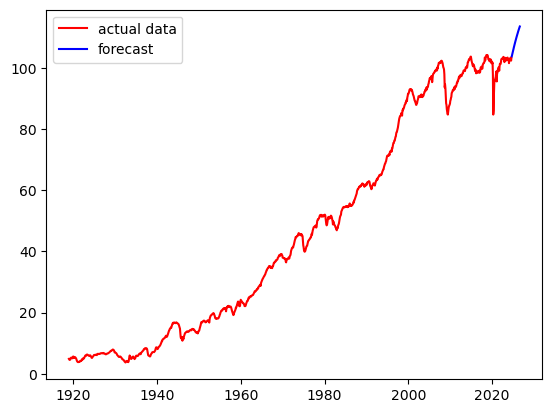

In [289]:
plt.plot(df['INDPRO'],'r',label='actual data')
plt.plot(pd.DataFrame(true_predictions,index=timestep_range,columns=['INDPRO']),'b',label='forecast')
plt.legend()
plt.show();

### Saving the LSTM model

In [291]:
save_model(model,'industrial_production_index_forecaster.keras')

In [292]:
load_model('industrial_production_index_forecaster.keras').summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 250)                 │         252,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 756,755 (2.89 MB)

 Trainable params: 252,251 (985.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 504,504 (1.92 MB)

## Forecasting Industrial Production Index using Facebook's Prophet library

In [294]:
temp = df['INDPRO'] # Creating a copy of the original dataframe
temp = pd.DataFrame(temp,columns=['INDPRO'])
temp.head()

,INDPRO
DATE,
1919-01-01,4.8654
1919-02-01,4.6504
1919-03-01,4.5160
1919-04-01,4.5966
1919-05-01,4.6235


In [295]:
temp.reset_index(inplace=True)
temp.columns = ['ds','y']
temp.head()

,ds,y
0,1919-01-01,4.8654
1,1919-02-01,4.6504
2,1919-03-01,4.5160
3,1919-04-01,4.5966
4,1919-05-01,4.6235


### Training the Prophet model and visualizing its predictions

In [297]:
prophet = Prophet()
prophet.fit(temp)

20:39:15 - cmdstanpy - INFO - Chain [1] start processing
20:39:17 - cmdstanpy - INFO - Chain [1] done processing


In [298]:
forecast_df = prophet.make_future_dataframe(periods=24,freq='MS')
forecast_df.head()

,ds
0,1919-01-01
1,1919-02-01
2,1919-03-01
3,1919-04-01
4,1919-05-01


In [299]:
forecast_df.tail()

,ds
1287,2026-04-01
1288,2026-05-01
1289,2026-06-01
1290,2026-07-01
1291,2026-08-01


In [300]:
forecast = prophet.predict(forecast_df)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1919-01-01,5.146632,2.136708,7.948880,5.146632,5.146632,-0.047607,-0.047607,-0.047607,-0.047607,-0.047607,-0.047607,0.0,0.0,0.0,5.099024
1,1919-02-01,5.153964,2.473174,8.116691,5.153964,5.153964,-0.020930,-0.020930,-0.020930,-0.020930,-0.020930,-0.020930,0.0,0.0,0.0,5.133035
2,1919-03-01,5.160588,2.115373,7.659995,5.160588,5.160588,-0.273393,-0.273393,-0.273393,-0.273393,-0.273393,-0.273393,0.0,0.0,0.0,4.887194
3,1919-04-01,5.167921,2.162385,7.811486,5.167921,5.167921,-0.157644,-0.157644,-0.157644,-0.157644,-0.157644,-0.157644,0.0,0.0,0.0,5.010276
4,1919-05-01,5.175017,2.381547,8.118630,5.175017,5.175017,-0.104190,-0.104190,-0.104190,-0.104190,-0.104190,-0.104190,0.0,0.0,0.0,5.070827


In [301]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

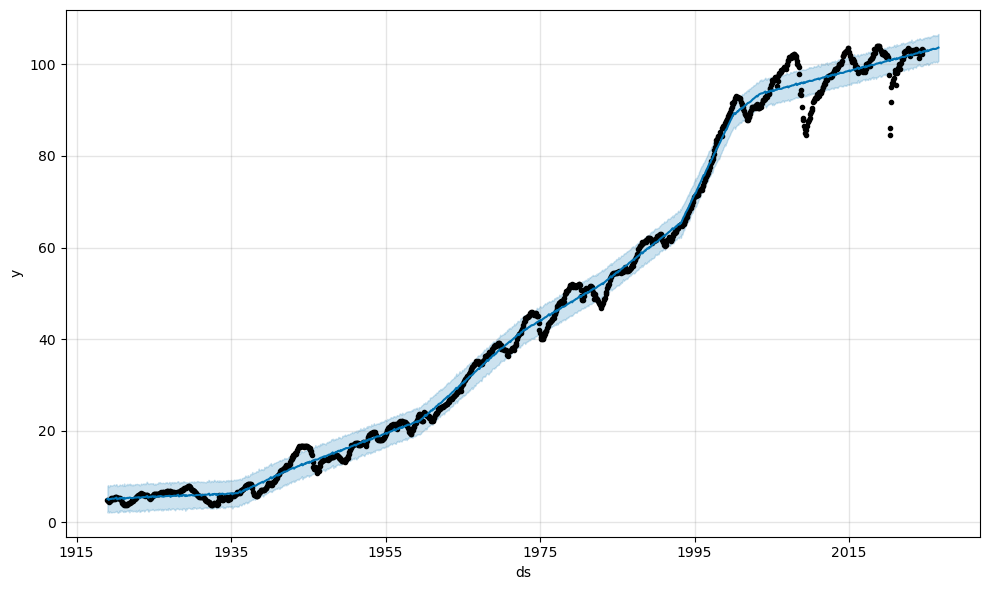

In [302]:
prophet.plot(forecast);

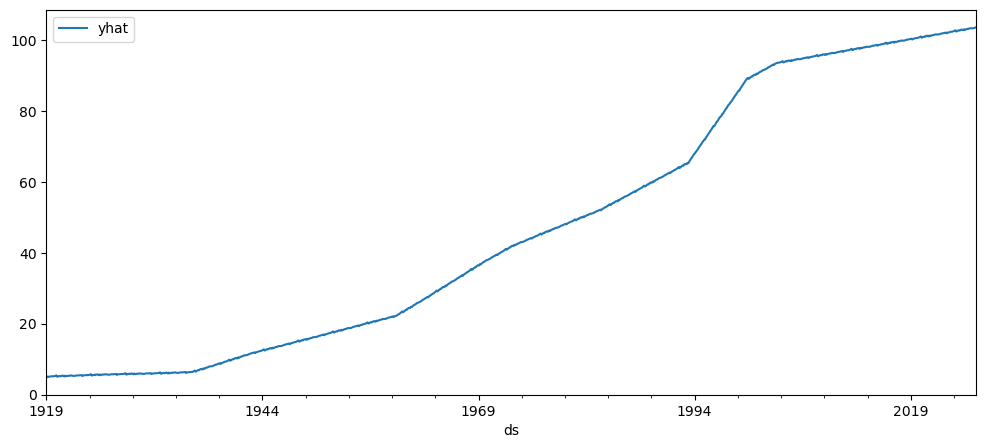

In [303]:
forecast.plot(x='ds',y='yhat',figsize=(12,5));

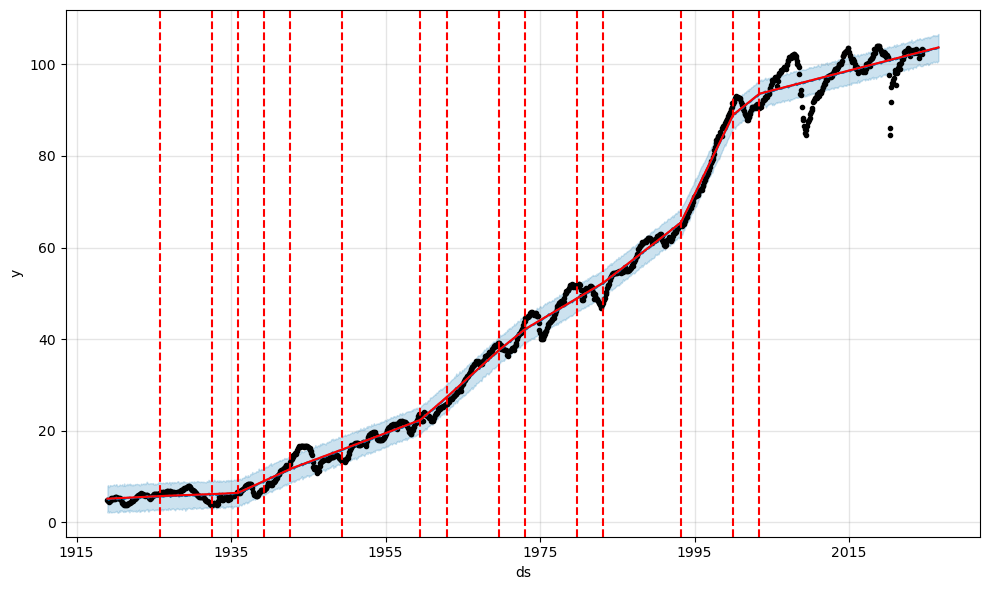

In [304]:
fig = prophet.plot(forecast)
add_changepoints_to_plot(ax=fig.gca(),m=prophet,fcst=forecast);

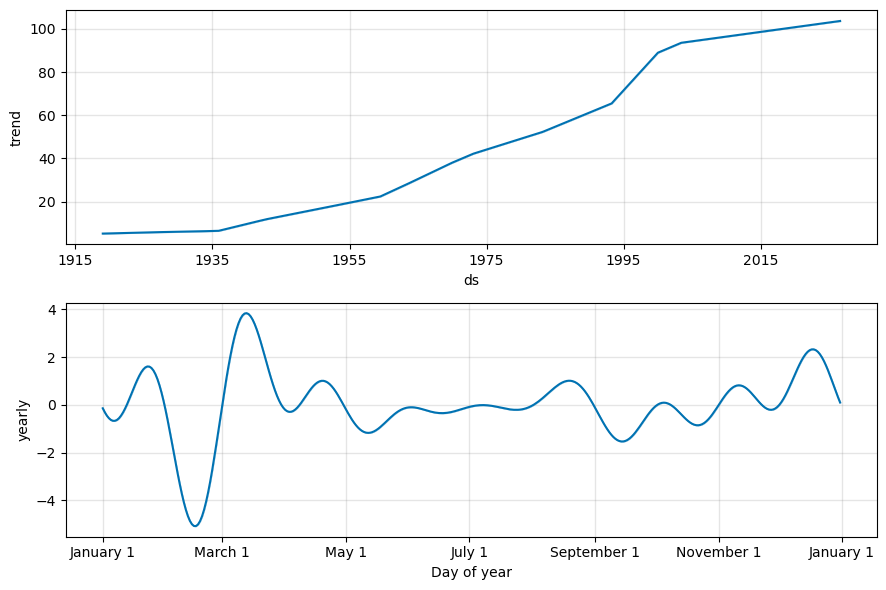

In [305]:
prophet.plot_components(forecast);

### Training the Prophet seasonal model and visualizing its predictions

In [307]:
prophet = Prophet(seasonality_mode='multiplicative')
prophet.fit(temp)

20:39:21 - cmdstanpy - INFO - Chain [1] start processing
20:39:21 - cmdstanpy - INFO - Chain [1] done processing


In [308]:
future_df = prophet.make_future_dataframe(periods=24,freq='MS')
forecast = prophet.predict(future_df)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1919-01-01,5.125311,2.107705,7.991338,5.125311,5.125311,-0.000404,-0.000404,-0.000404,-0.000404,-0.000404,-0.000404,0.0,0.0,0.0,5.123242
1,1919-02-01,5.131287,2.417747,7.981139,5.131287,5.131287,-0.000156,-0.000156,-0.000156,-0.000156,-0.000156,-0.000156,0.0,0.0,0.0,5.130485
2,1919-03-01,5.136685,2.340296,8.025808,5.136685,5.136685,-0.004318,-0.004318,-0.004318,-0.004318,-0.004318,-0.004318,0.0,0.0,0.0,5.114503
3,1919-04-01,5.142662,2.395844,8.029480,5.142662,5.142662,-0.002024,-0.002024,-0.002024,-0.002024,-0.002024,-0.002024,0.0,0.0,0.0,5.132253
4,1919-05-01,5.148445,2.225032,8.088234,5.148445,5.148445,-0.001490,-0.001490,-0.001490,-0.001490,-0.001490,-0.001490,0.0,0.0,0.0,5.140774


In [309]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yhat'],
      dtype='object')

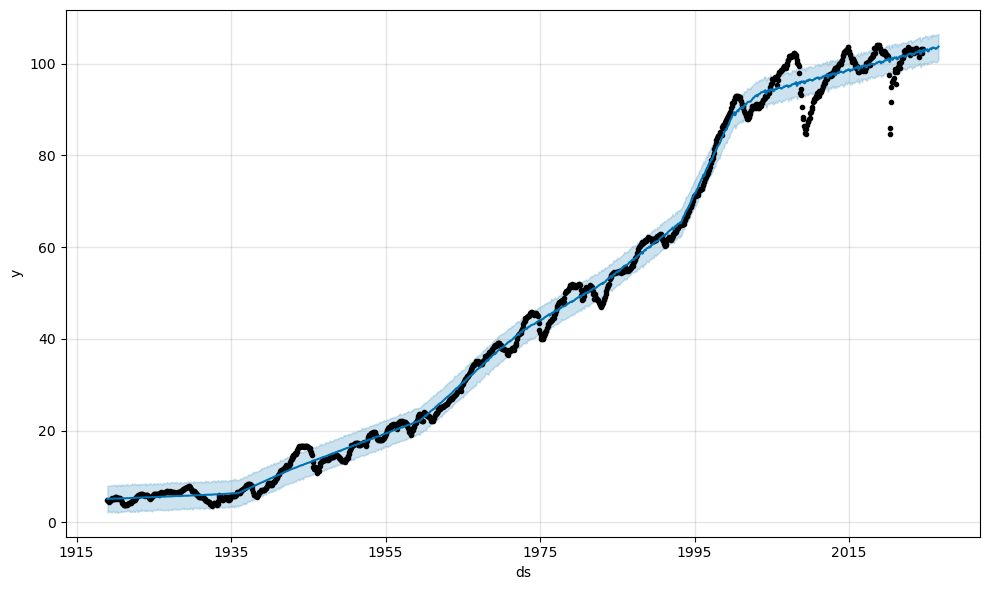

In [310]:
prophet.plot(forecast);

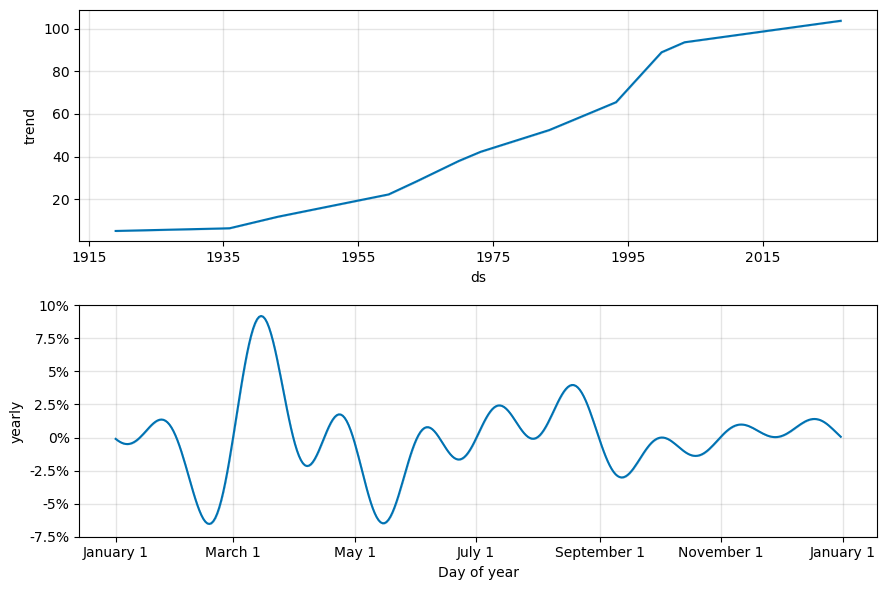

In [311]:
prophet.plot_components(forecast);

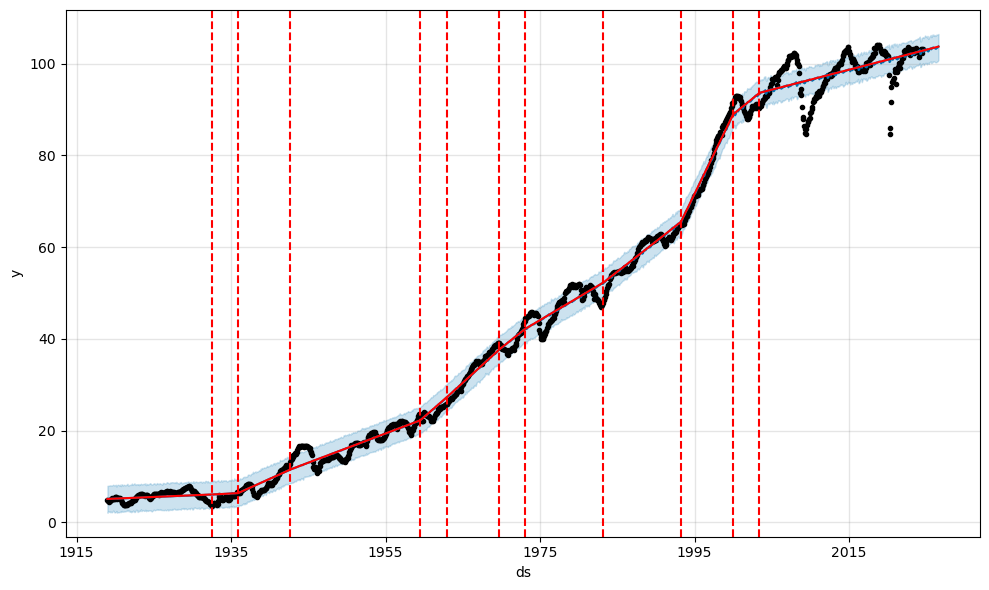

In [312]:
fig = prophet.plot(forecast)
ax = add_changepoints_to_plot(ax=fig.gca(),m=prophet,fcst=forecast);

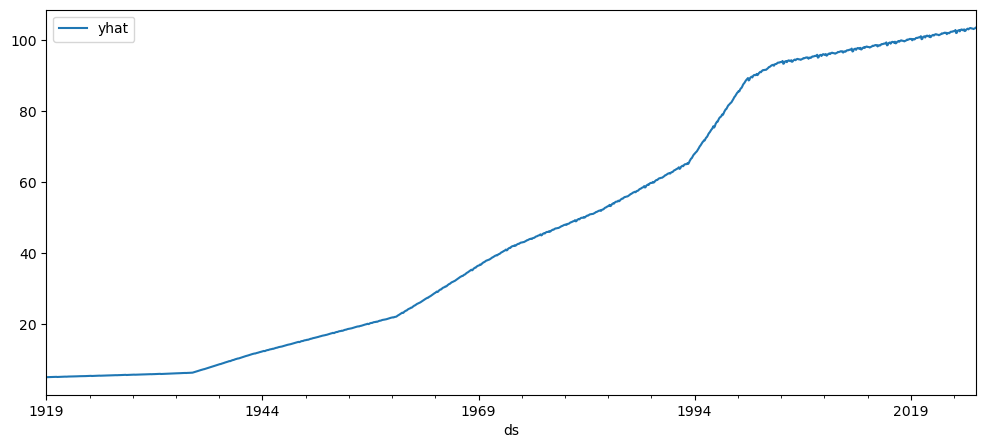

In [313]:
forecast.plot(x='ds',y='yhat',figsize=(12,5));

### Applying Prophet on train and test data

In [315]:
temp.shape

(1268, 2)

In [316]:
train = temp[:1244]
test = temp[1244:]
train.shape, test.shape

((1244, 2), (24, 2))

In [317]:
prophet = Prophet()
prophet.fit(train)

20:39:24 - cmdstanpy - INFO - Chain [1] start processing
20:39:24 - cmdstanpy - INFO - Chain [1] done processing


In [318]:
forecast = prophet.predict(test)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-09-01,101.947115,98.850889,104.847754,101.947115,101.947115,-0.107115,-0.107115,-0.107115,-0.107115,-0.107115,-0.107115,0.0,0.0,0.0,101.840000
1,2022-10-01,101.983284,98.759556,104.947544,101.983284,101.983284,-0.083469,-0.083469,-0.083469,-0.083469,-0.083469,-0.083469,0.0,0.0,0.0,101.899815
2,2022-11-01,102.020658,98.985890,104.990826,102.020658,102.020658,-0.065627,-0.065627,-0.065627,-0.065627,-0.065627,-0.065627,0.0,0.0,0.0,101.955031
3,2022-12-01,102.056827,98.970643,104.865186,102.056827,102.056827,-0.018728,-0.018728,-0.018728,-0.018728,-0.018728,-0.018728,0.0,0.0,0.0,102.038099
4,2023-01-01,102.094201,98.858711,105.166724,102.094201,102.094201,-0.033895,-0.033895,-0.033895,-0.033895,-0.033895,-0.033895,0.0,0.0,0.0,102.060307


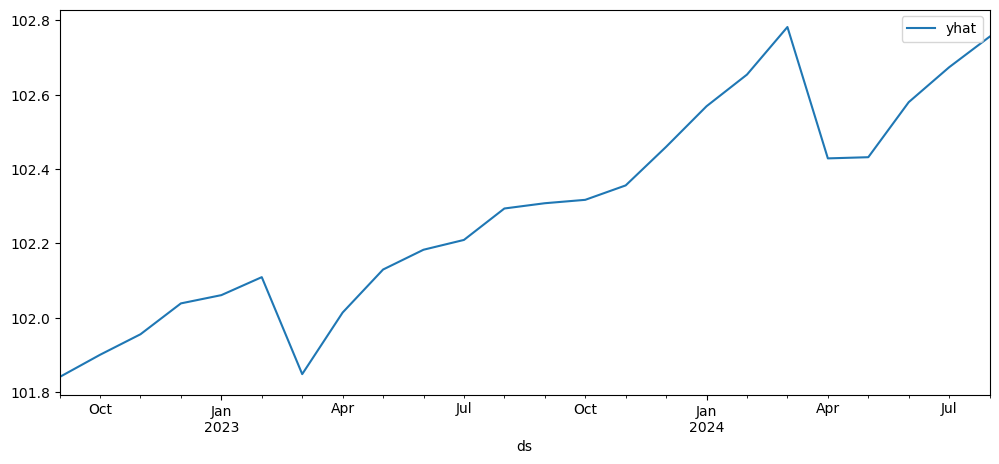

In [319]:
forecast.plot(x='ds',y='yhat',figsize=(12,5));

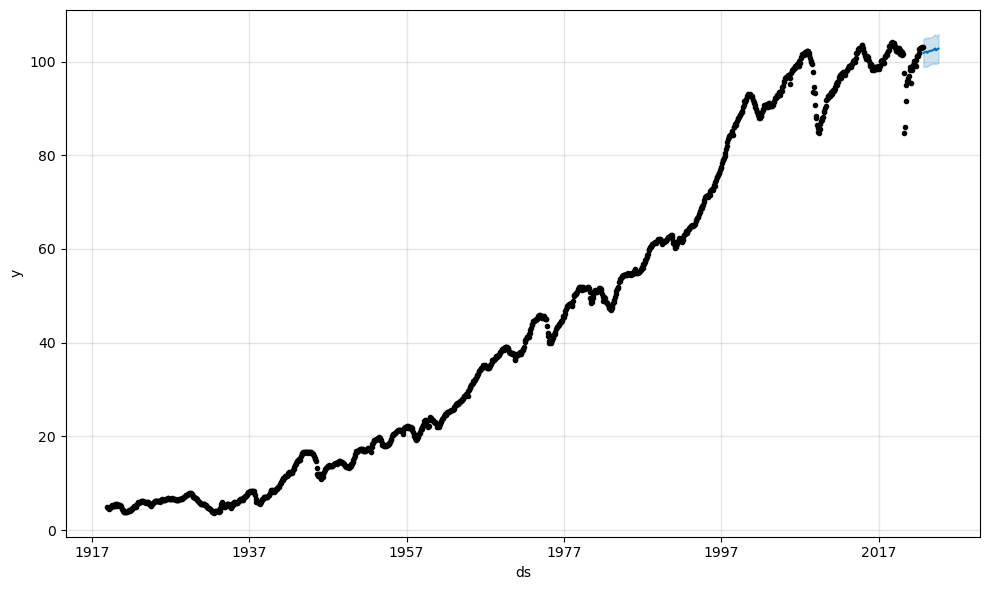

In [320]:
prophet.plot(forecast);

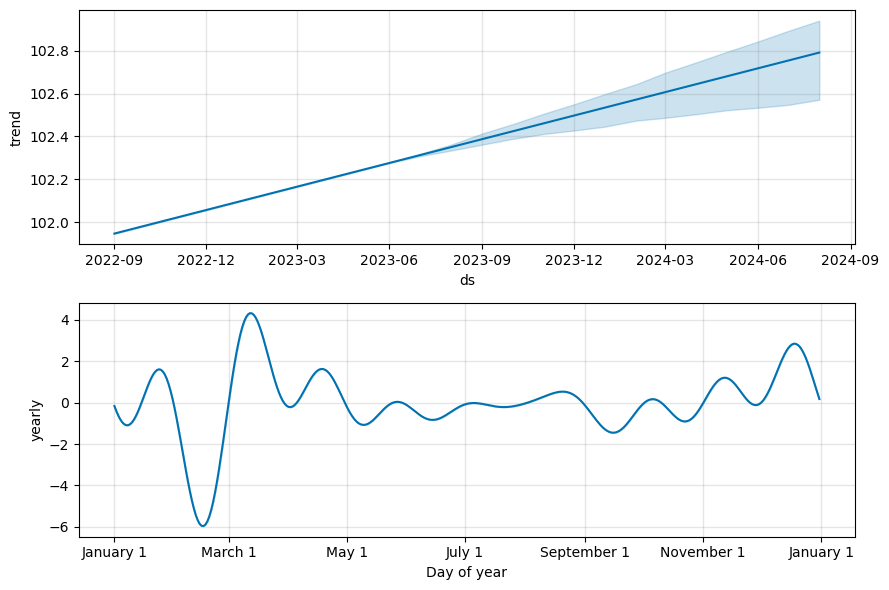

In [321]:
prophet.plot_components(forecast);

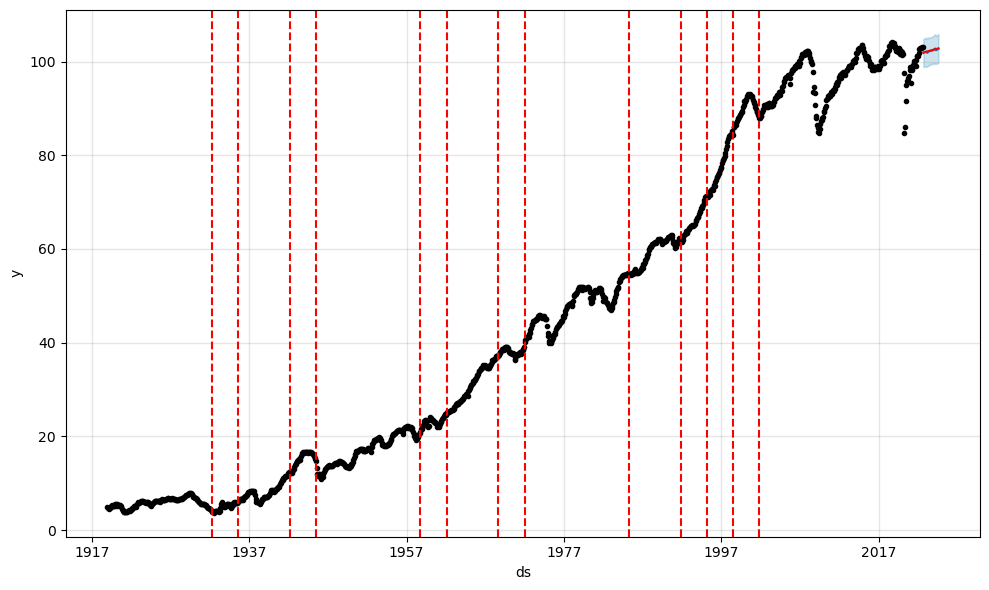

In [322]:
fig = prophet.plot(forecast)
ax = add_changepoints_to_plot(fig.gca(),prophet,forecast);

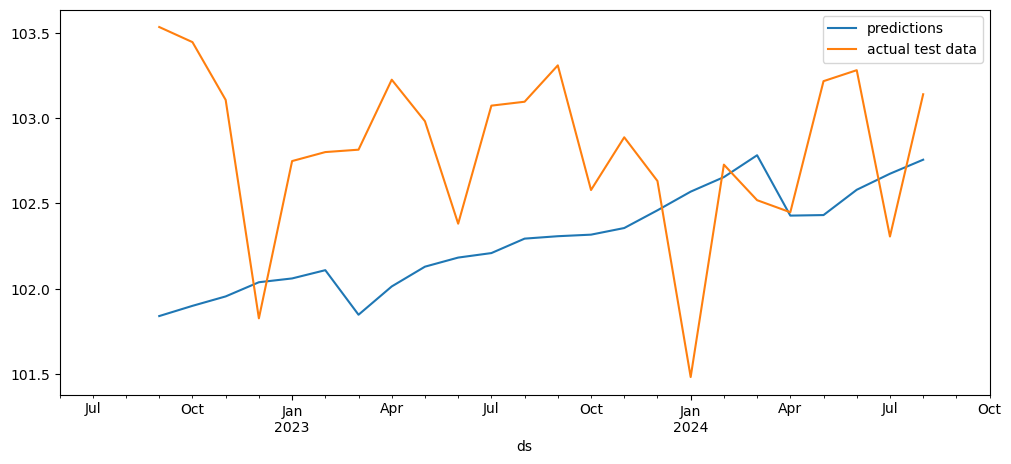

In [323]:
ax = forecast.plot(x='ds',y='yhat',figsize=(12,5),label='predictions')
test.plot(x='ds',y='y',figsize=(12,5),label='actual test data',ax=ax,xlim=(datetime(2022,6,1),datetime(2024,10,1)));

### Cross validating the Prophet model

In [325]:
# Initial training period
initial = 6 * 365
initial = str(initial) + ' days'
initial

'2190 days'

In [326]:
# Period length of cross validation
period = 5 * 365
period = str(period) + ' days'
period

'1825 days'

In [327]:
# Future forecast horizon
horizon = 2 * 365
horizon = str(horizon) + ' days'
horizon

'730 days'

In [328]:
df_cv = cross_validation(model=prophet,initial=initial,period=period,horizon=horizon)
df_cv.head()

  0%|          | 0/20 [00:00<?, ?it/s]

20:39:27 - cmdstanpy - INFO - Chain [1] start processing
20:39:28 - cmdstanpy - INFO - Chain [1] done processing
20:39:28 - cmdstanpy - INFO - Chain [1] start processing
20:39:28 - cmdstanpy - INFO - Chain [1] done processing
20:39:29 - cmdstanpy - INFO - Chain [1] start processing
20:39:29 - cmdstanpy - INFO - Chain [1] done processing
20:39:29 - cmdstanpy - INFO - Chain [1] start processing
20:39:29 - cmdstanpy - INFO - Chain [1] done processing
20:39:29 - cmdstanpy - INFO - Chain [1] start processing
20:39:29 - cmdstanpy - INFO - Chain [1] done processing
20:39:30 - cmdstanpy - INFO - Chain [1] start processing
20:39:30 - cmdstanpy - INFO - Chain [1] done processing
20:39:30 - cmdstanpy - INFO - Chain [1] start processing
20:39:30 - cmdstanpy - INFO - Chain [1] done processing
20:39:31 - cmdstanpy - INFO - Chain [1] start processing
20:39:31 - cmdstanpy - INFO - Chain [1] done processing
20:39:31 - cmdstanpy - INFO - Chain [1] start processing
20:39:31 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1925-09-01,6.319953,5.669809,6.994281,6.0751,1925-08-25
1,1925-10-01,6.405300,5.748200,6.973084,6.3170,1925-08-25
2,1925-11-01,6.364904,5.730518,6.935256,6.4514,1925-08-25
3,1925-12-01,6.354998,5.691962,6.952734,6.5320,1925-08-25
4,1926-01-01,6.385501,5.775086,7.005200,6.4245,1925-08-25


In [329]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,77 days,15.043233,3.878561,2.970424,0.123108,0.068893,0.117961,0.354167
1,78 days,15.301698,3.911739,3.038881,0.124536,0.073182,0.119536,0.333333
2,79 days,15.590511,3.948482,3.090629,0.121414,0.073182,0.116919,0.333333
3,80 days,15.974388,3.996797,3.152381,0.118270,0.073182,0.112841,0.333333
4,82 days,15.969736,3.996215,3.149642,0.116493,0.068893,0.110950,0.333333
...,...,...,...,...,...,...,...,...
428,725 days,18.762543,4.331575,3.186881,0.147216,0.055895,0.135956,0.437500
429,726 days,18.458538,4.296340,3.133527,0.145050,0.050329,0.133630,0.458333
430,728 days,20.523120,4.530245,3.307332,0.146323,0.055895,0.134815,0.458333
431,729 days,21.357200,4.621385,3.423174,0.147301,0.060850,0.135754,0.437500


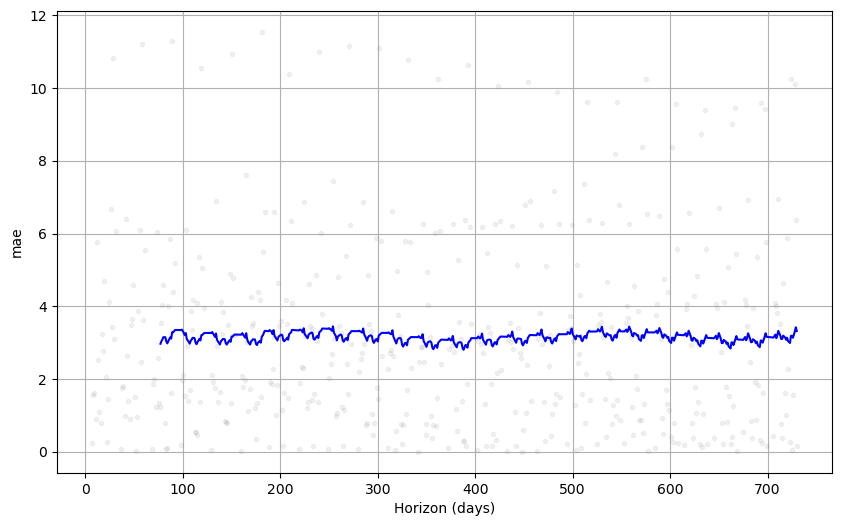

In [330]:
plot_cross_validation_metric(df_cv,metric='mae');

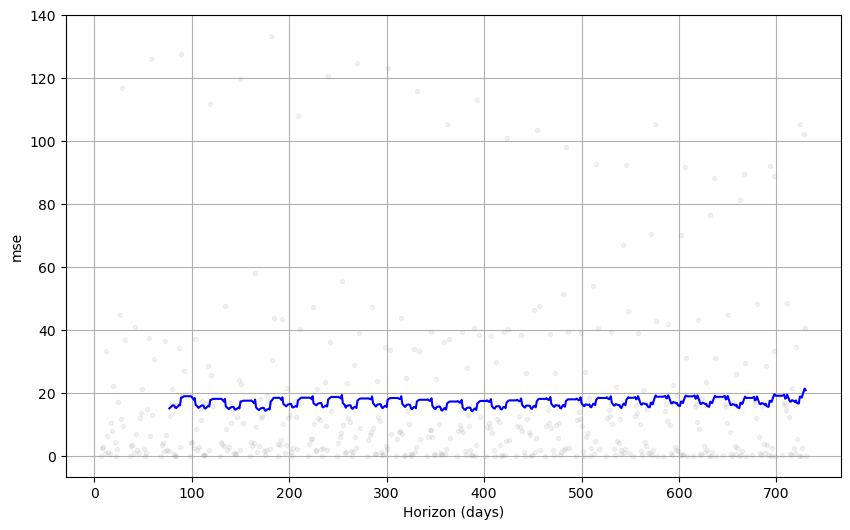

In [331]:
plot_cross_validation_metric(df_cv,metric='mse');

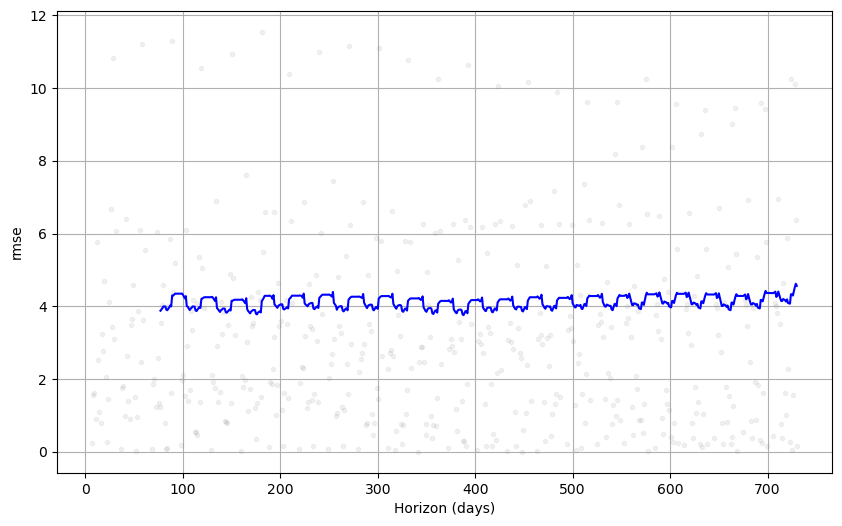

In [332]:
plot_cross_validation_metric(df_cv,metric='rmse');

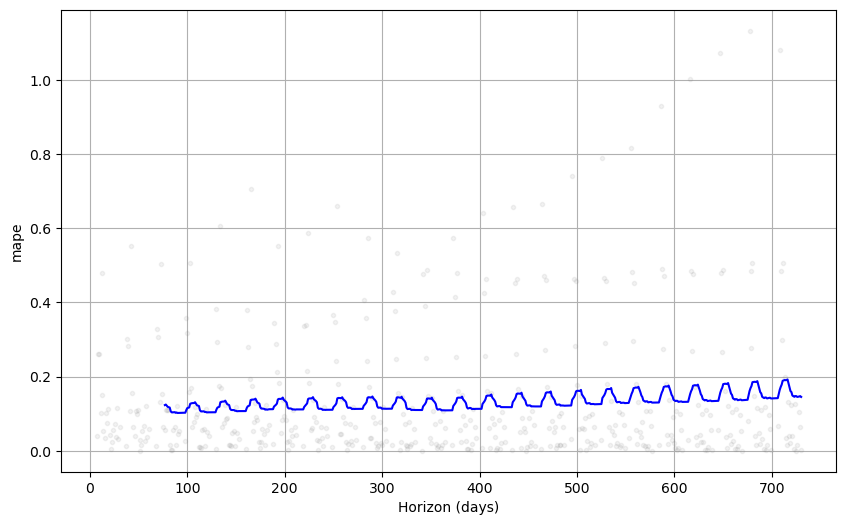

In [333]:
plot_cross_validation_metric(df_cv,metric='mape');

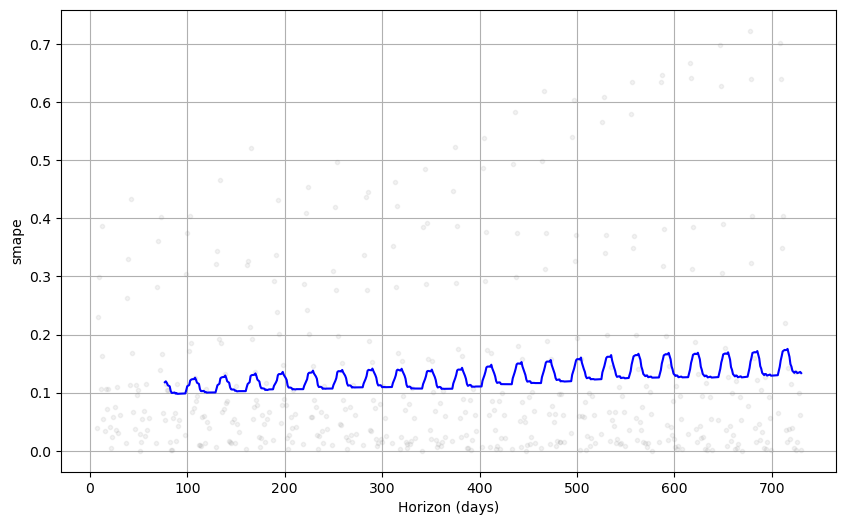

In [334]:
plot_cross_validation_metric(df_cv,metric='smape');

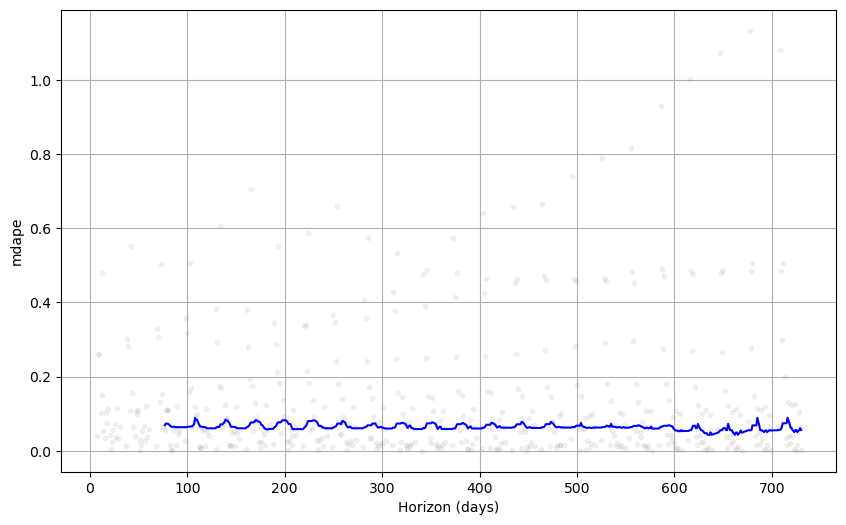

In [335]:
plot_cross_validation_metric(df_cv,metric='mdape');

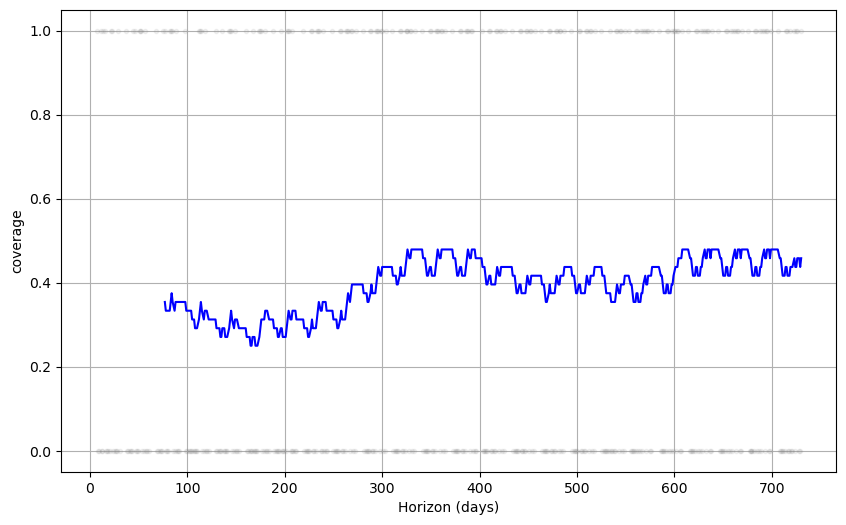

In [336]:
plot_cross_validation_metric(df_cv,metric='coverage');